# Lossy compression


This notebook reproduces the results of the `Lossy compression` results in the paper.

We assumes the `ephys-compression/scripts/benchmark-lossly-sim.py` and `ephys-compression/scripts/benchmark-lossly-exp.py` scripts have been run and the `../data/ephys-compression-results/results-lossy-sim` and `../data/ephys-compression-results/results-lossy-exp` are available.

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [46]:
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import spikeinterface as si
import spikeinterface.preprocessing as spre
import spikeinterface.comparison as sc

from utils import prettify_axes

%matplotlib inline

In [47]:
figsize_single = (10, 5)
figsize_multi_2rows = (10, 9)
figsize_multi_3rows = (10, 12)
figsize_multi_4rows = (10, 12)

In [48]:
data_folder = Path("../data/")
results_folder = Path("../results/")

save_fig = True
fig_folder = results_folder / "figures"
fig_folder.mkdir(exist_ok=True, parents=True)
panel_names = ["A", "B", "C", "D", "E", "F"]

results_lossy_sim_folder = data_folder / "ephys-compression-results" / "results-lossy-sim"
results_lossy_exp_folder = data_folder / "ephys-compression-results" / "results-lossy-exp"

In [49]:
res_sim = pd.read_csv(results_lossy_sim_folder / "benchmark-lossy-sim.csv", index_col=False)
res_sim_wfs = pd.read_csv(results_lossy_sim_folder / "benchmark-lossy-sim-waveforms.csv", index_col=False)
res_exp = pd.read_csv(results_lossy_exp_folder / "benchmark-lossy-exp.csv", index_col=False)

In [50]:
probe_names = {"Neuropixels1.0": "NP1",
               "Neuropixels2.0": "NP2"}
for probe, probe_name in probe_names.items():
    res_sim.loc[res_sim.query(f"probe == '{probe}'").index, "probe"] = probe_name
    res_sim_wfs.loc[res_sim_wfs.query(f"probe == '{probe}'").index, "probe"] = probe_name
    res_exp.loc[res_exp.query(f"probe == '{probe}'").index, "probe"] = probe_name
probes = ["NP1", "NP2"]

In [51]:
res_exp = res_exp.drop_duplicates()

In [52]:
bit_cmap = plt.get_cmap("Purples_r")
wv_cmap = plt.get_cmap("Greens_r")

res_exp_wv = res_exp.query("strategy == 'wavpack'")
wv_order = [0] + list(np.sort(np.unique(res_exp_wv.factor))[::-1][:-1])
res_exp_bit = res_exp.query("strategy == 'bit_truncation'")
bit_order = list(np.sort(np.unique(res_exp_bit.factor)))
bit_labels = [int(b) for b in bit_order]
wv_labels = wv_order

res_sim_wv = res_sim.query("strategy == 'wavpack'")
res_sim_bit = res_sim.query("strategy == 'bit_truncation'")

In [53]:
bit_colors = {str(float(bit)): bit_cmap(val) for bit, val in zip(bit_order,
                                                                 np.linspace(0.05, 0.7, len(bit_order)))}
wv_colors = {str(float(bps)): wv_cmap(val) for bps, val in zip(wv_order,
                                                               np.linspace(0.05, 0.7, len(wv_order)))}

### CR *versus* RMSE 

<>:107: DeprecationWarning: invalid escape sequence \m
<>:107: DeprecationWarning: invalid escape sequence \m
/tmp/ipykernel_344/460806950.py:107: DeprecationWarning: invalid escape sequence \m
  _ = fig_8.text(0, 0.22, "RMSE ($\mu$V)", transform=fig_8.transFigure, rotation=90, fontsize=15)


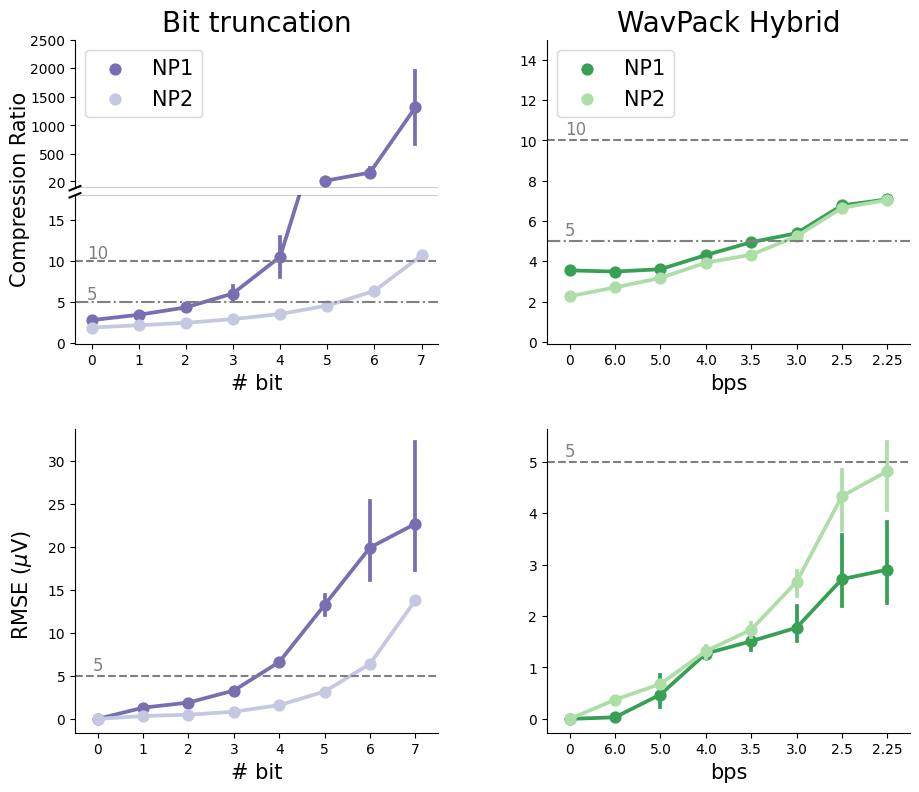

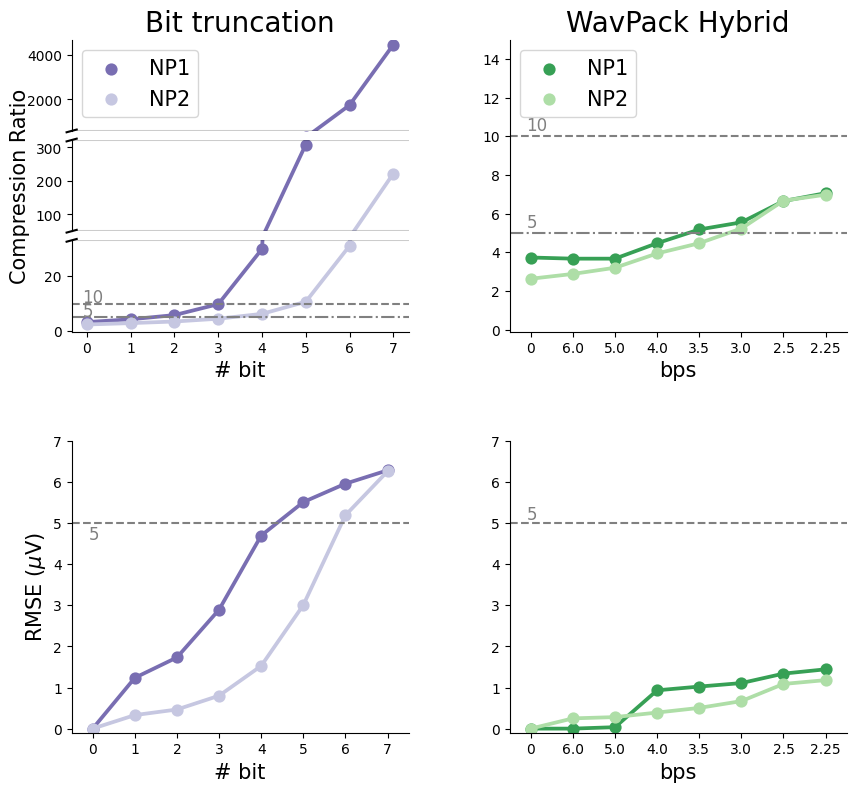

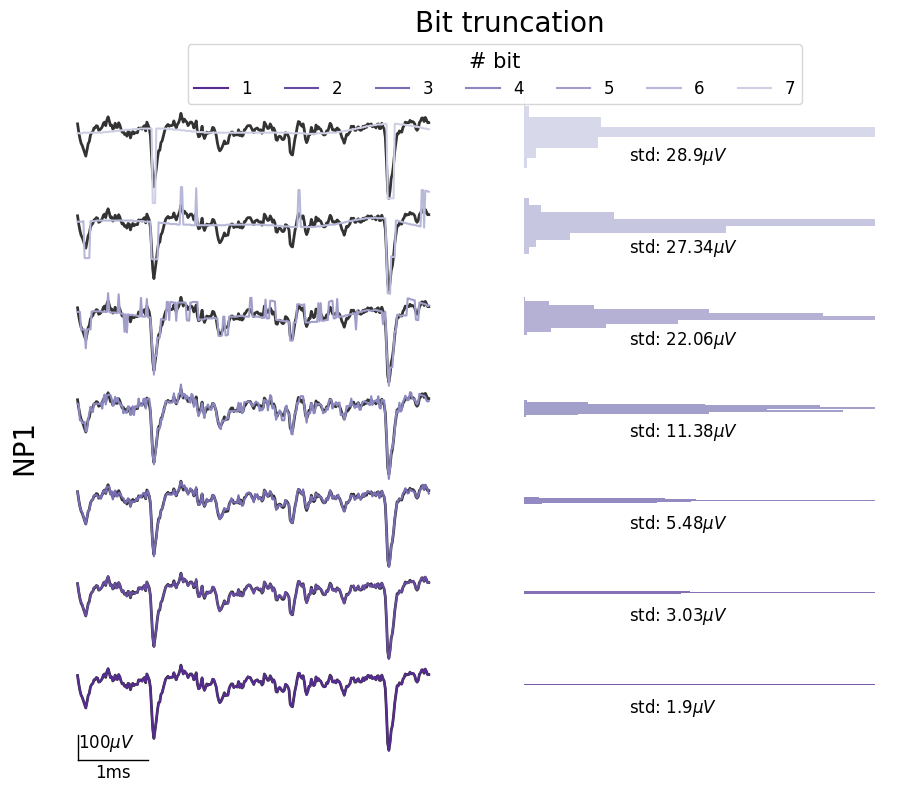

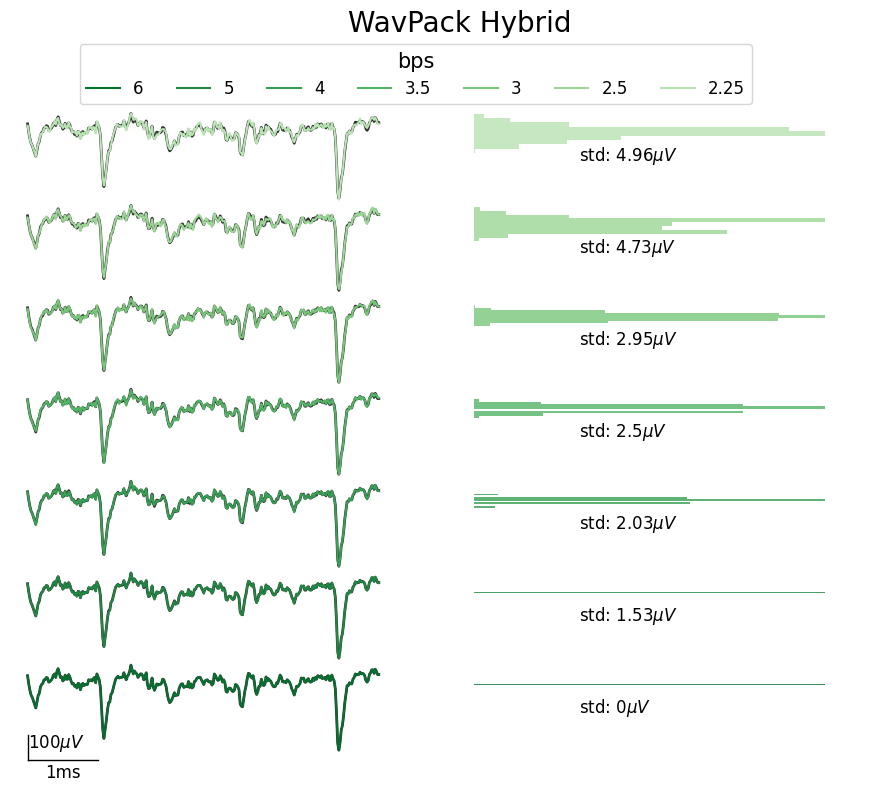

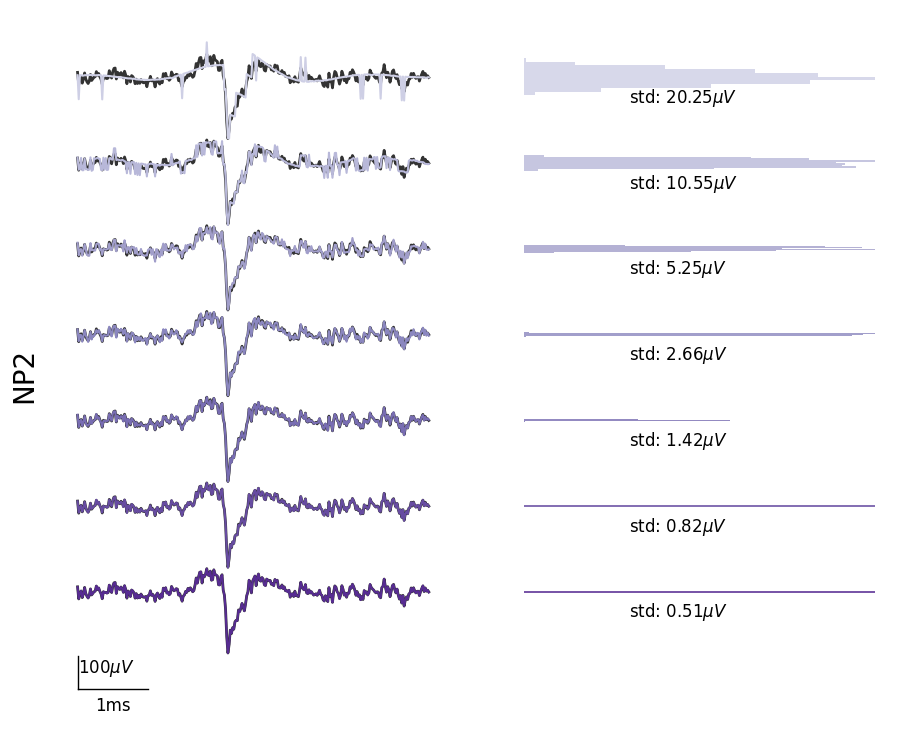

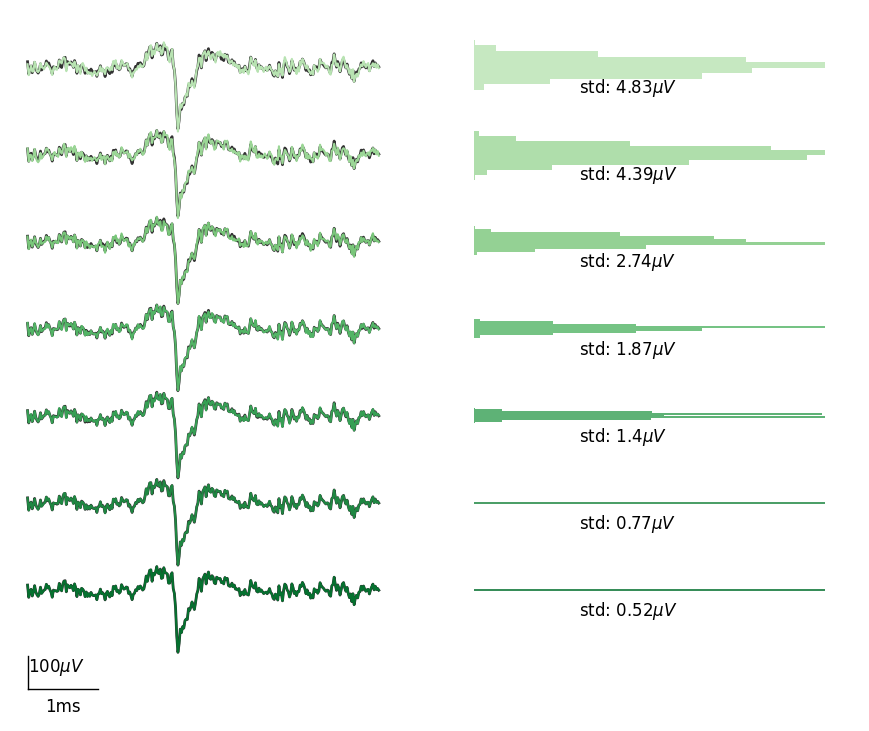

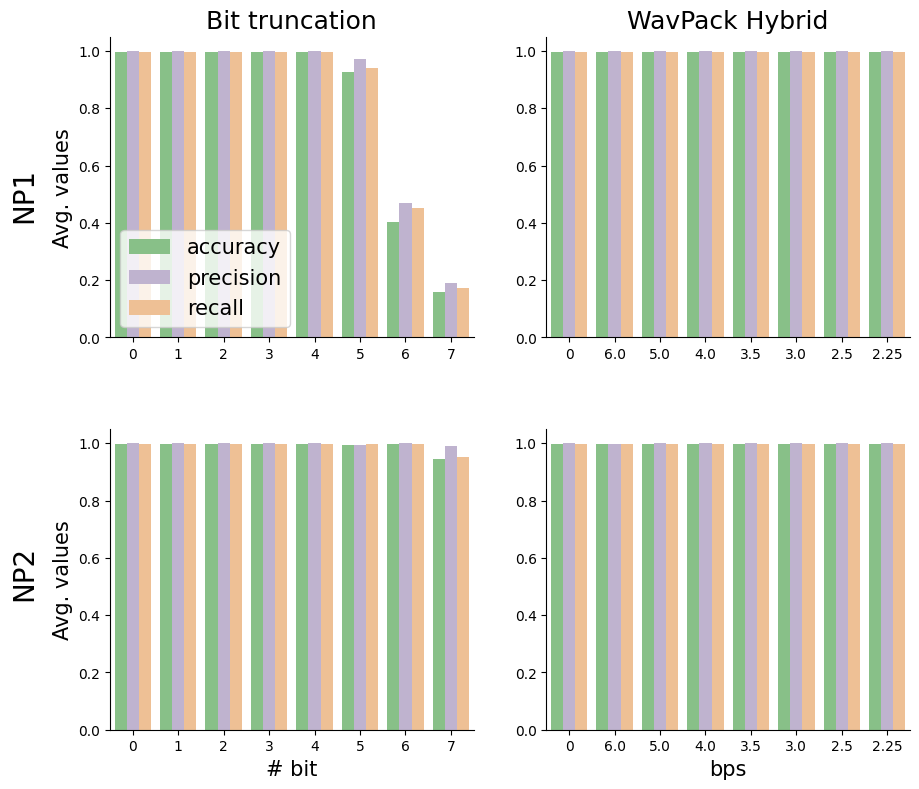

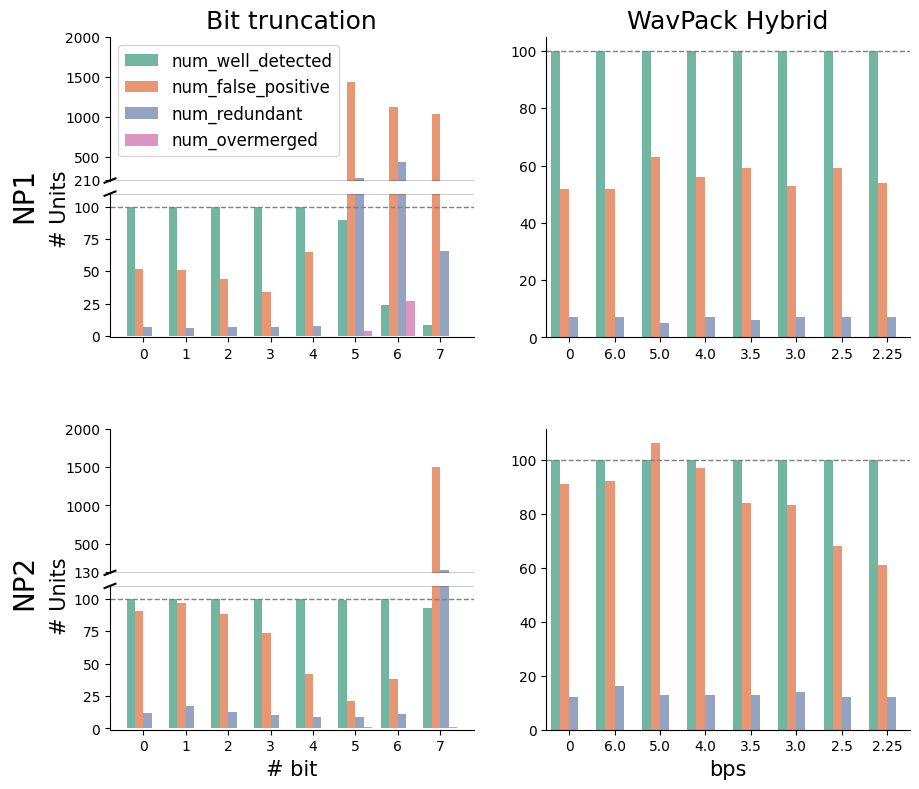

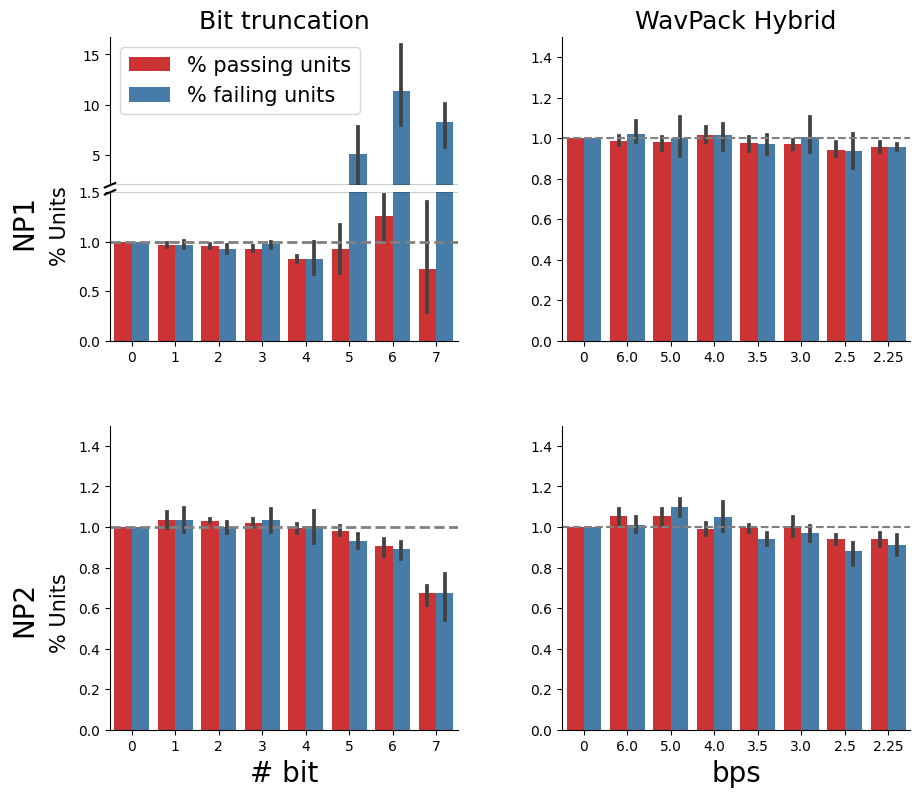

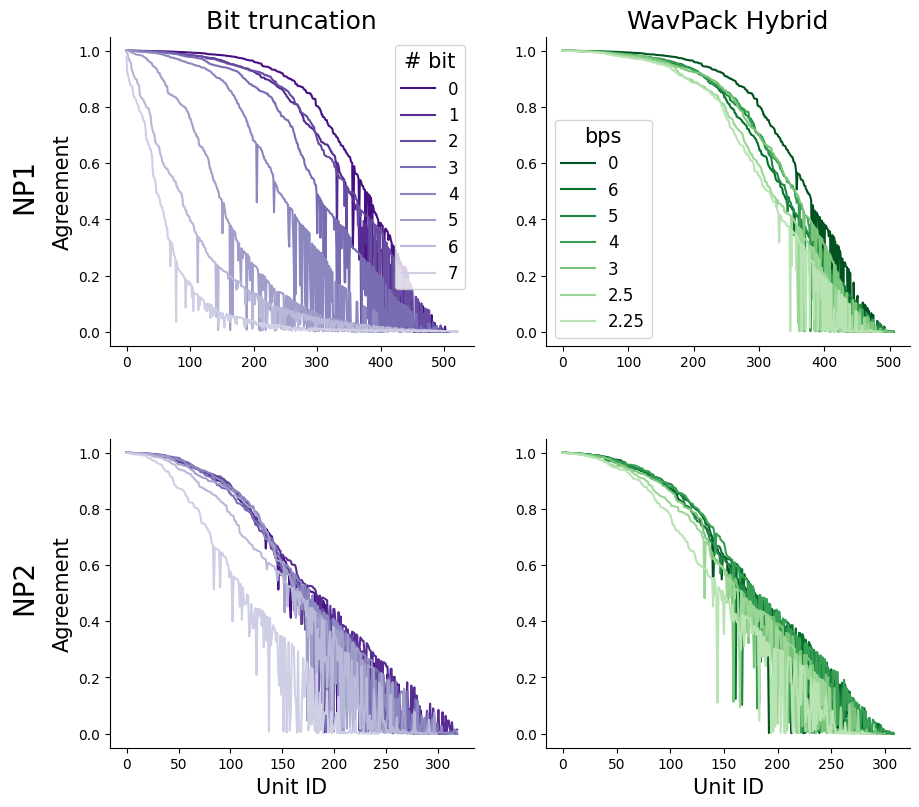

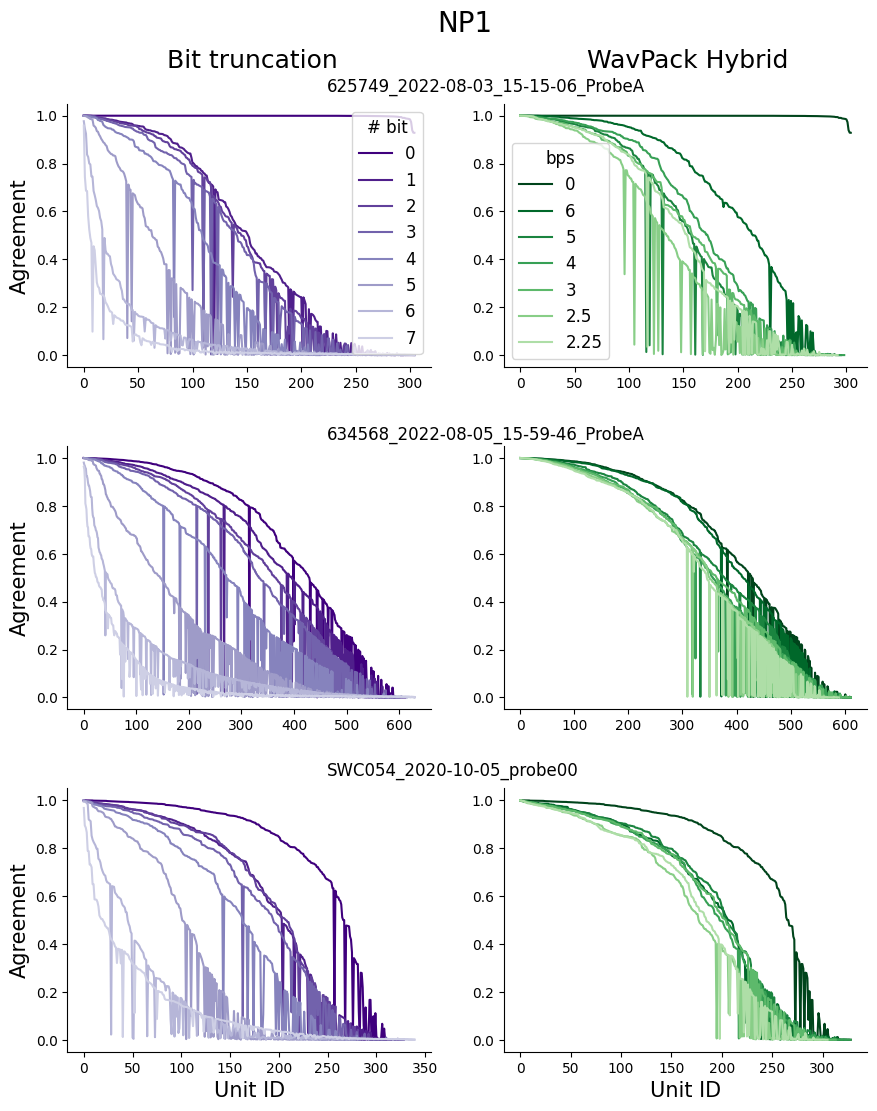

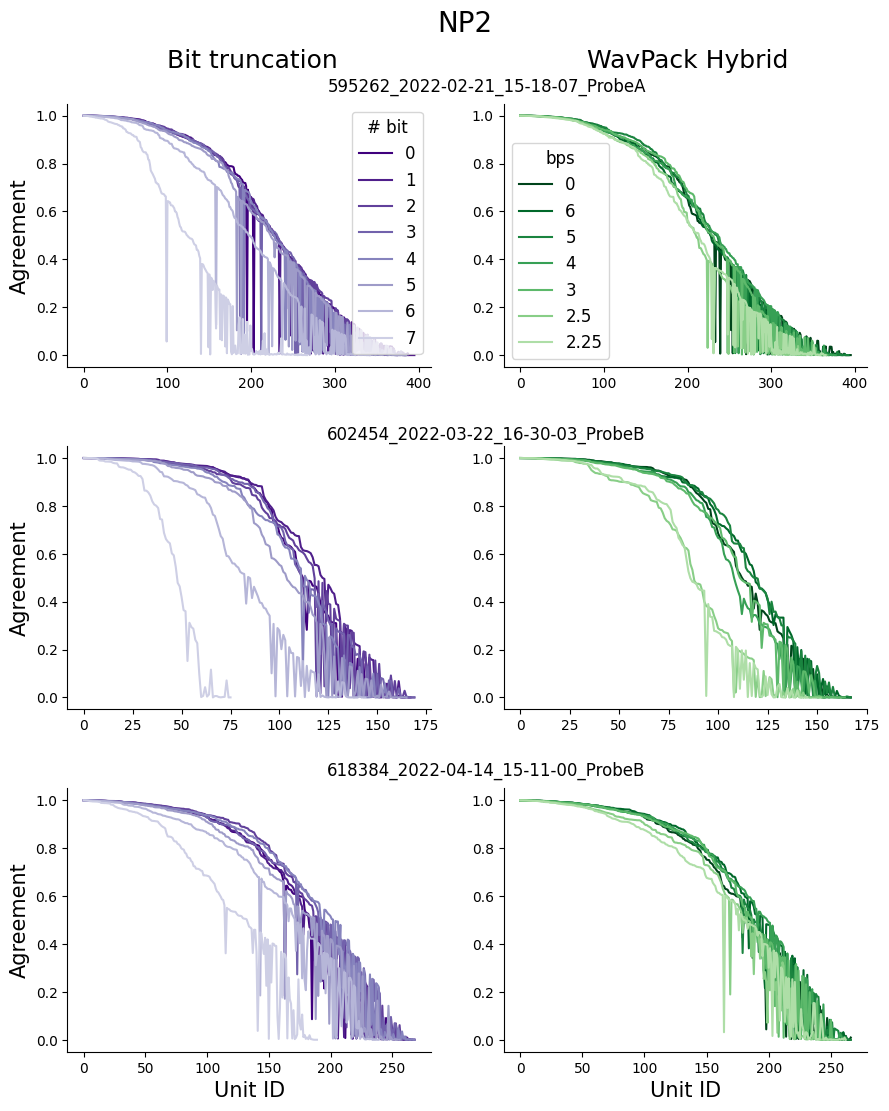

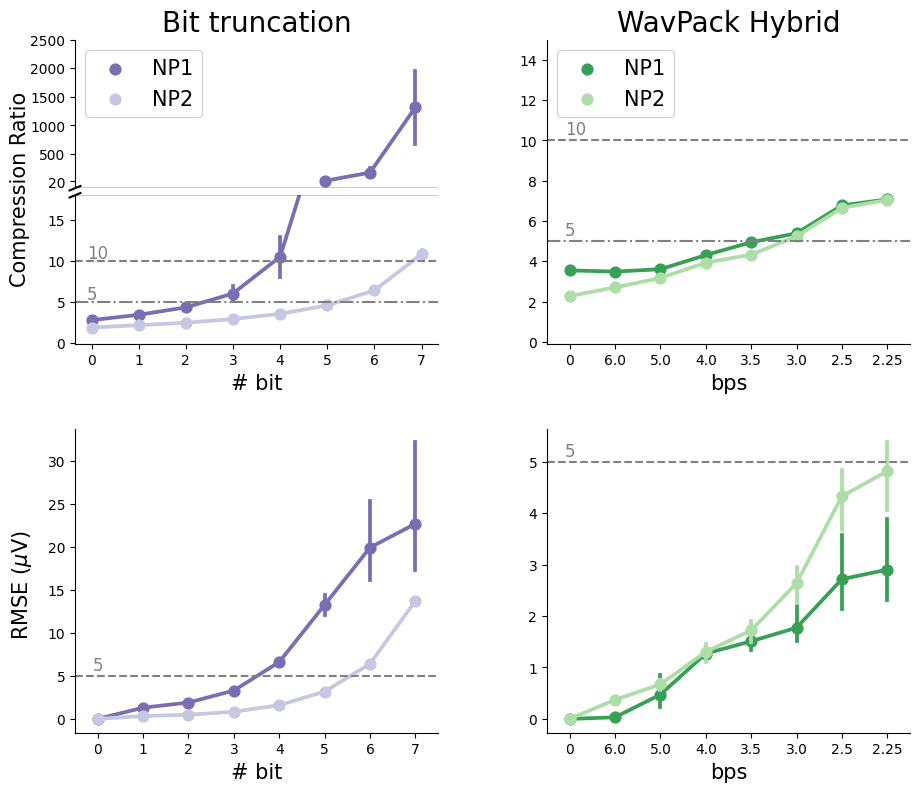

In [54]:
fig_8 = plt.figure(figsize=figsize_multi_2rows)

color = bit_cmap.name
np1_color = dict(NP1=(0.47320261437908495, 0.43267973856209146, 0.6993464052287581))

gs = GridSpec(9, 2, hspace=0.1, wspace=0.3)
ax1_top = fig_8.add_subplot(gs[0:2, 0])
ax1_bottom = fig_8.add_subplot(gs[2:4, 0])
ax12 = fig_8.add_subplot(gs[:4, 1])
ax21 = fig_8.add_subplot(gs[5:, 0])
ax22 = fig_8.add_subplot(gs[5:, 1])

axs = [ax1_top, ax1_bottom, ax12, ax21, ax22]

# bit truncation
sns.pointplot(data=res_exp_bit.query("factor > 4 and probe == 'NP1'"), 
              x="factor", y="CR", hue="probe", ax=ax1_top, errorbar="se",
              palette=np1_color)
sns.pointplot(data=res_exp_bit, x="factor", y="CR", hue="probe", ax=ax1_bottom, errorbar="se", palette=color)

top_lim = -99
bottom_lims = [-0.1, 18]

ax1_top.set_xlim(-5.5, 2.5)
ax1_top.set_ylim(bottom=top_lim)
ax1_top.axhline(top_lim, ls="-", color="k", alpha=0.2)
ax1_top.set_xticks([])
ax1_top.set_xlabel("")
ax1_top.set_ylabel("")
yticks = [20] + list(ax1_top.get_yticks())
ax1_top.set_yticks(sorted(yticks)[2:])
ax1_bottom.set_ylim(bottom_lims)
ax1_bottom.axhline(bottom_lims[1], ls="-", color="k", alpha=0.2)

sns.despine(ax=ax1_bottom)
sns.despine(ax=ax1_top, bottom=True)
# sns.despine(ax=ax1_mid, bottom=True)

d = .015
kwargs = dict(transform=ax1_top.transAxes, color='k', clip_on=False)
ax1_top.plot((-d, +d), (-d, +d), **kwargs)

# kwargs = dict(transform=ax1_mid.transAxes, color='k', clip_on=False)
# ax1_mid.plot((-d, +d), (-d, +d), **kwargs)
# ax1_mid.plot((-d, +d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax1_bottom.transAxes)
ax1_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)

#remove one of the legend
ax1_top.legend_.remove()
ax1_bottom.legend_.remove()

ax = ax1_bottom
ax.axhline(10, color="grey", ls="--")
ax.axhline(5, color="grey", ls="-.")
ax.text(-0.1, 10.3, "10", color="grey", fontsize=12)
ax.text(-0.1, 5.3, "5", color="grey", fontsize=12)
ax.set_xlabel("# bit")
# ax1_mid.set_ylabel("Compression Ratio", fontsize=15)
ax1_bottom.set_ylabel("")
ax1_bottom.set_xticklabels(bit_labels)

ax = ax21
sns.pointplot(data=res_exp_bit, x="factor", y="rmse", hue="probe", ax=ax, palette=color)
ax.axhline(5, color="grey", ls="--")
ax.text(-0.1, 5.7, "5", color="grey", fontsize=12)
ax.set_ylabel("")
ax.set_xticklabels(bit_labels)
ax.set_xlabel("# bit")
ax.get_legend().remove()


# wavpack
color = wv_cmap.name

ax = ax12
sns.pointplot(data=res_exp_wv, x="factor", y="CR", hue="probe", ax=ax, errorbar="se", 
              order=wv_order, palette=color)
ax.set_ylim(-0.1, 15)
ax.axhline(10, color="grey", ls="--")
ax.axhline(5, color="grey", ls="-.")
ax.text(-0.1, 10.3, "10", color="grey", fontsize=12)
ax.text(-0.1, 5.3, "5", color="grey", fontsize=12)
ax.set_xlabel("bps")
ax.get_legend().remove()
ax.set_ylabel("")
ax.set_xticklabels(wv_labels)

ax = ax22
sns.pointplot(data=res_exp_wv, x="factor", y="rmse", hue="probe", order=wv_order, ax=ax, palette=color)
ax.axhline(5, color="grey", ls="--")
ax.text(-0.1, 5.1, "5", color="grey", fontsize=12)
ax.set_xticklabels(wv_labels)
ax.set_xlabel("bps")
ax.set_ylabel("")
ax.get_legend().remove()

handles, labels = ax1_bottom.get_legend_handles_labels()
ax1_top.legend(handles, labels, fontsize=15, loc=2)
handles, labels = ax12.get_legend_handles_labels()
ax12.legend(handles, labels, fontsize=15, loc=2)


fig_8.subplots_adjust(left=0.065)
_ = fig_8.text(0, 0.61, "Compression Ratio", transform=fig_8.transFigure, rotation=90, fontsize=15)
_ = fig_8.text(0, 0.22, "RMSE ($\mu$V)", transform=fig_8.transFigure, rotation=90, fontsize=15)
ax1_top.set_title("Bit truncation", fontsize=20)
ax12.set_title("WavPack Hybrid", fontsize=20)

prettify_axes(axs)

<>:74: DeprecationWarning: invalid escape sequence \m
<>:74: DeprecationWarning: invalid escape sequence \m
/tmp/ipykernel_344/4230988791.py:74: DeprecationWarning: invalid escape sequence \m
  ax.set_ylabel("RMSE ($\mu$V)")


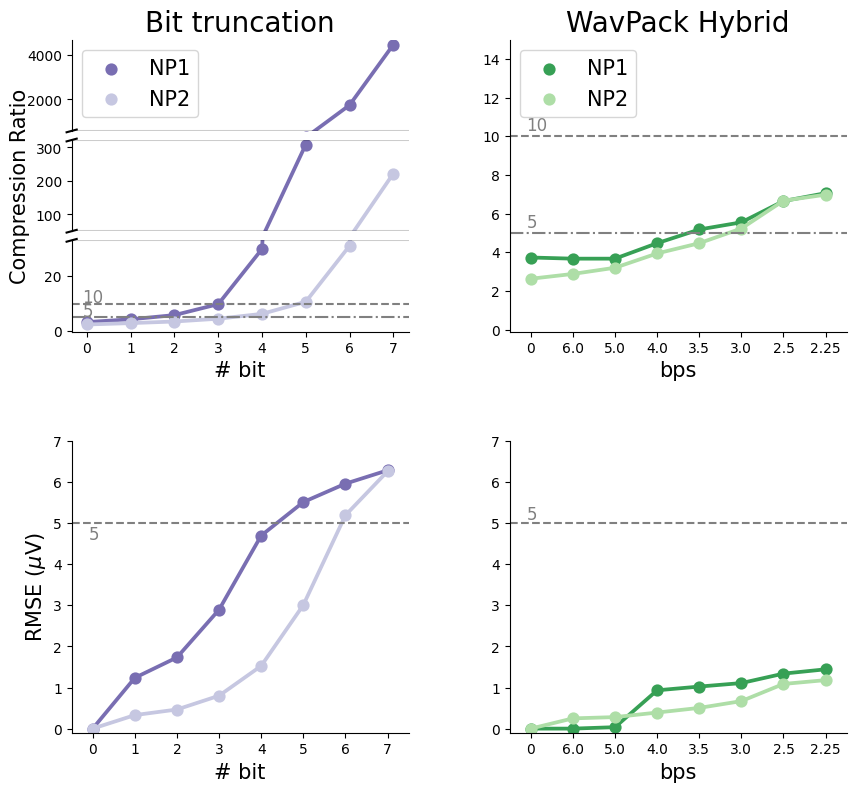

In [55]:
fig_S5 = plt.figure(figsize=figsize_multi_2rows)

color = bit_cmap.name

# make 2
gs = GridSpec(7, 2, hspace=0.1, wspace=0.3)
ax1_top = fig_S5.add_subplot(gs[0, 0])
ax1_mid = fig_S5.add_subplot(gs[1, 0])
ax1_bottom = fig_S5.add_subplot(gs[2, 0])
ax12 = fig_S5.add_subplot(gs[:3, 1])
ax21 = fig_S5.add_subplot(gs[4:, 0])
ax22 = fig_S5.add_subplot(gs[4:, 1])

axs = [ax1_top, ax1_mid, ax1_bottom, ax12, ax21, ax22]

# bit truncation
sns.pointplot(data=res_sim_bit, x="factor", y="CR", hue="probe", ax=ax1_top, errorbar="se", palette=color)
sns.pointplot(data=res_sim_bit, x="factor", y="CR", hue="probe", ax=ax1_mid, errorbar="se", palette=color)
sns.pointplot(data=res_sim_bit, x="factor", y="CR", hue="probe", ax=ax1_bottom, errorbar="se", palette=color)

top_lim = 600
mid_lims = [50, 322]
bottom_lims = [-0.1, 33]

ax1_top.set_ylim(bottom=600)
ax1_top.axhline(top_lim, ls="-", color="k", alpha=0.2)
ax1_top.set_xticks([])
ax1_top.set_xlabel("")
ax1_mid.set_ylim(mid_lims)
for lim in mid_lims:
    ax1_mid.axhline(lim, ls="-", color="k", alpha=0.2)
ax1_mid.set_xticks([])
ax1_mid.set_xlabel("")
ax1_bottom.set_ylim(bottom_lims)
ax1_bottom.axhline(bottom_lims[1], ls="-", color="k", alpha=0.2)

sns.despine(ax=ax1_bottom)
sns.despine(ax=ax1_top, bottom=True)
sns.despine(ax=ax1_mid, bottom=True)

d = .015
kwargs = dict(transform=ax1_top.transAxes, color='k', clip_on=False)
ax1_top.plot((-d, +d), (-d, +d), **kwargs)

kwargs = dict(transform=ax1_mid.transAxes, color='k', clip_on=False)
ax1_mid.plot((-d, +d), (-d, +d), **kwargs)
ax1_mid.plot((-d, +d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax1_bottom.transAxes)
ax1_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)

#remove one of the legend
ax1_top.get_legend().remove()
ax1_mid.get_legend().remove()
ax1_bottom.get_legend().remove()

ax = ax1_bottom
ax.axhline(10, color="grey", ls="--")
ax.axhline(5, color="grey", ls="-.")
ax.text(-0.1, 10.3, "10", color="grey", fontsize=12)
ax.text(-0.1, 5.3, "5", color="grey", fontsize=12)
ax.set_xlabel("# bit")

ax1_top.set_ylabel("")
ax1_mid.set_ylabel("Compression Ratio", fontsize=15)
ax1_bottom.set_ylabel("")
ax1_bottom.set_xticklabels(bit_labels)

ax = ax21
sns.pointplot(data=res_sim_bit, x="factor", y="rmse", hue="probe", ax=ax, palette=color)
ax.axhline(5, color="grey", ls="--")
ax.set_ylim(-0.1, 7)
ax.text(-0.1, 4.6, "5", color="grey", fontsize=12)
ax.set_ylabel("RMSE ($\mu$V)")
ax.set_xticklabels(bit_labels)
ax.set_xlabel("# bit")
ax.get_legend().remove()

# wavpack
color = wv_cmap.name

ax = ax12
sns.pointplot(data=res_sim_wv, x="factor", y="CR", hue="probe", ax=ax, errorbar="se", 
              order=wv_order, palette=color)

ax.axhline(10, color="grey", ls="--")
ax.axhline(5, color="grey", ls="-.")
ax.text(-0.1, 10.3, "10", color="grey", fontsize=12)
ax.text(-0.1, 5.3, "5", color="grey", fontsize=12)
ax.set_xlabel("bps")
ax.set_ylim(-0.1, 15)
ax.set_ylabel("")
ax.set_xticklabels(wv_labels)
ax.get_legend().remove()

ax = ax22
sns.pointplot(data=res_sim_wv, x="factor", y="rmse", hue="probe", order=wv_order, ax=ax, palette=color)
ax.axhline(5, color="grey", ls="--")
ax.text(-0.1, 5.1, "5", color="grey", fontsize=12)
ax.set_ylim(-0.1, 7)
ax.set_xticklabels(wv_labels)
ax.set_xlabel("bps")
ax.set_ylabel("")
ax.get_legend().remove()

ax1_top.set_title("Bit truncation", fontsize=20)
ax12.set_title("WavPack Hybrid", fontsize=20)
handles, labels = ax1_top.get_legend_handles_labels()
ax1_top.legend(handles, labels, fontsize=15, loc=2)
handles, labels = ax12.get_legend_handles_labels()
ax12.legend(handles, labels, fontsize=15, loc=2)

prettify_axes(axs)

In [56]:
if save_fig:
    fig_8.savefig(fig_folder / "fig8.pdf")
    fig_S5.savefig(fig_folder / "figS5.pdf")

## Plot trace snippets

In [57]:
NP1_session = "625749_2022-08-03_15-15-06_ProbeA"
NP2_session = "595262_2022-02-21_15-18-07_ProbeA"

In [58]:
factors_traces = {
    "bit_truncation": [1, 2, 3, 4, 5, 6, 7],
    "wavpack": [6, 5, 4, 3.5, 3, 2.5, 2.25]
}

NP1 - bit_truncation-1 error distribution plotted as a bar
NP1 - wavpack-6 error distribution plotted as a bar
NP1 - wavpack-5 error distribution plotted as a bar
NP2 - bit_truncation-1 error distribution plotted as a bar
NP2 - bit_truncation-2 error distribution plotted as a bar
NP2 - wavpack-6 error distribution plotted as a bar
NP2 - wavpack-5 error distribution plotted as a bar


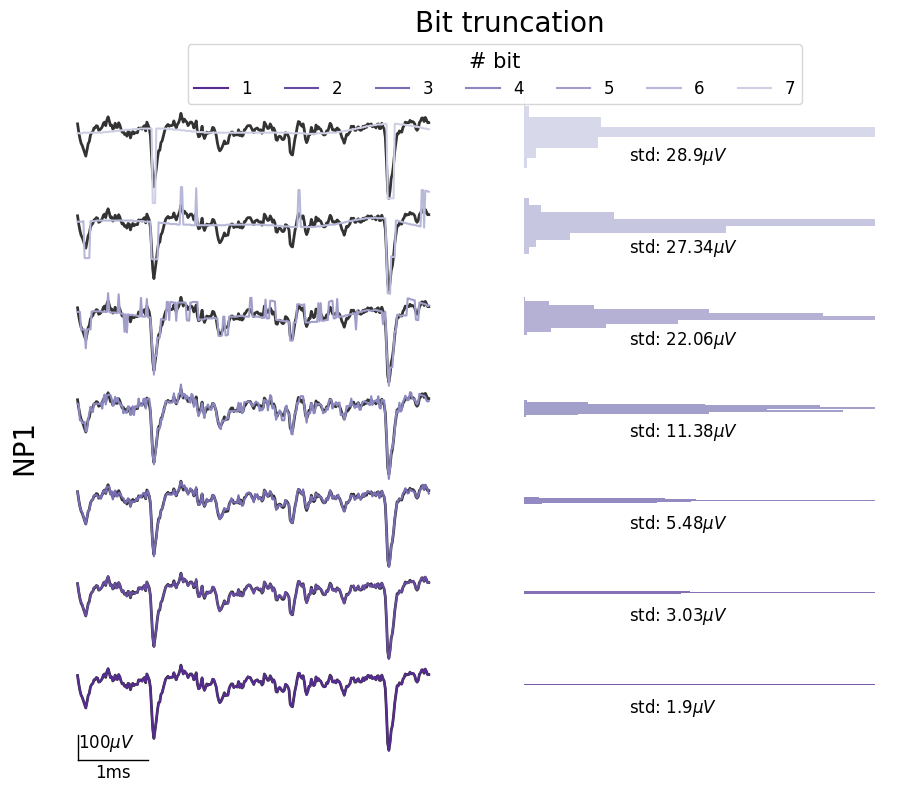

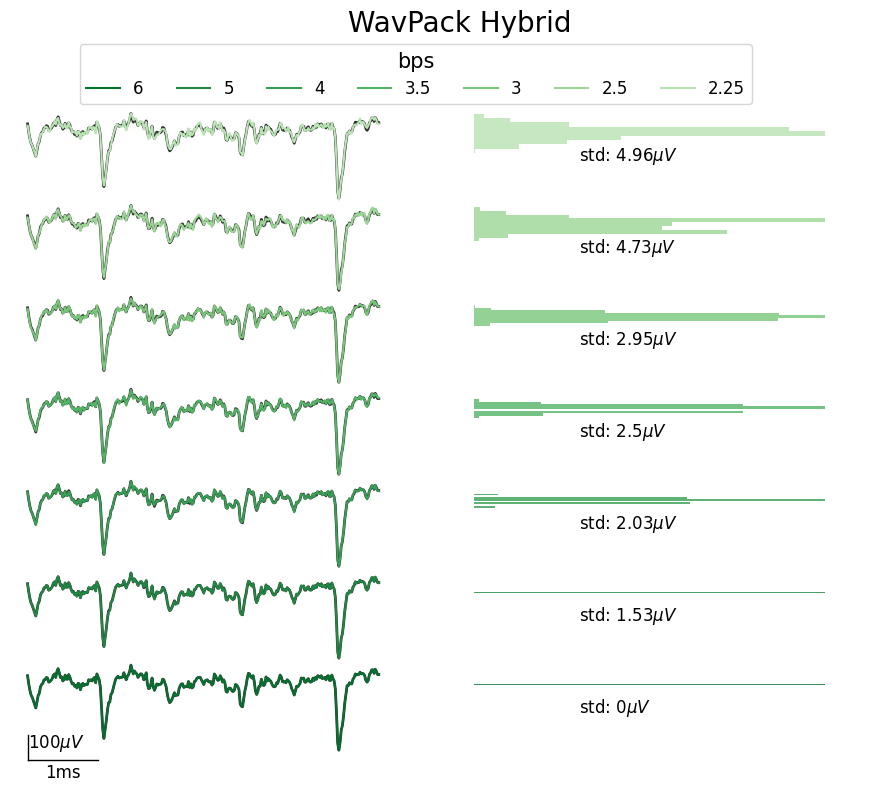

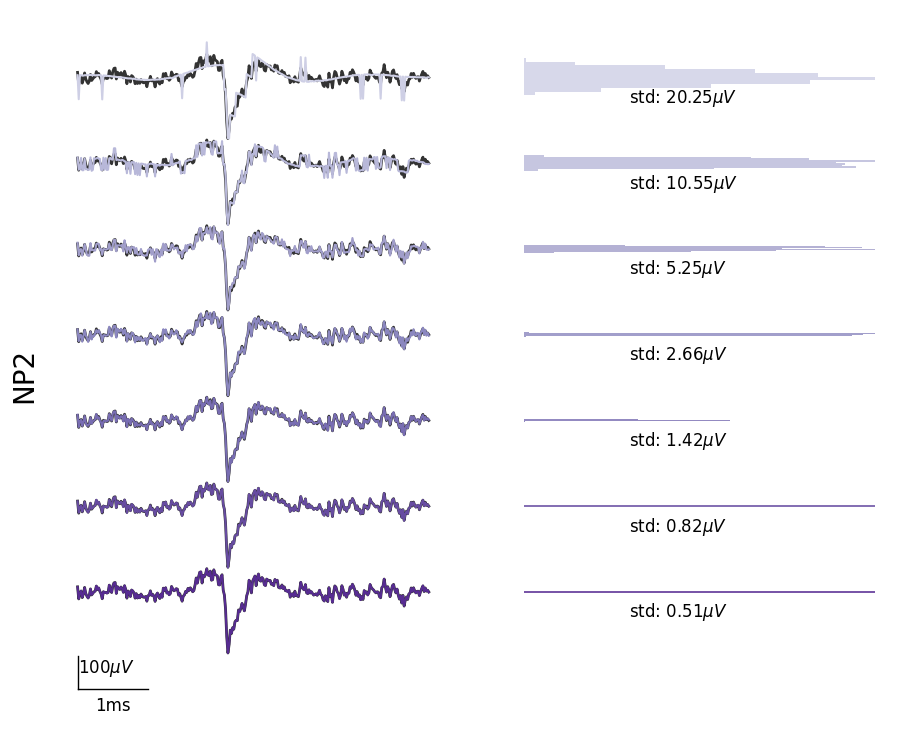

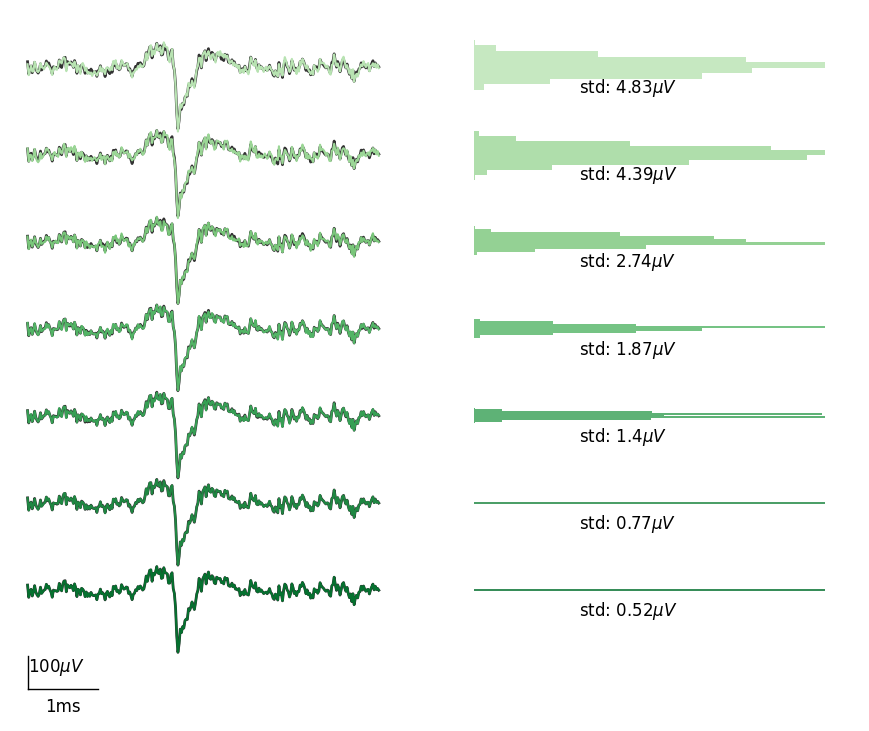

In [59]:
time_range_NP1 = [1.13, 1.14]
time_range_NP2 = [1.11, 1.12]
fs = 30000
error_range = [0, 2]
fig9_panels = {}

for i_p, probe in enumerate(["NP1", "NP2"]):
    if probe == "NP1":
        session_name = NP1_session
        row = 0
        channel_index = 165
        time_range = time_range_NP1
        error_limit = 2
    else:
        session_name = NP2_session
        row = 1
        channel_index = 300
        time_range = time_range_NP2
        error_limit = 1
    rec_or = si.read_zarr(results_lossy_exp_folder / "compressed_recordings" /
                          f"{session_name}_bit_truncation-0.zarr")
    rec_or = spre.highpass_filter(rec_or)
    rec_or = spre.common_reference(rec_or)

    start_frame = int(time_range[0] * fs)
    end_frame = int(time_range[1] * fs)
    start_frame_error = int(error_range[0] * fs)
    end_frame_error = int(error_range[1] * fs)
    channel_ids = [rec_or.channel_ids[channel_index]]

    ts = np.arange(0, end_frame- start_frame) / fs * 1000
    traces_or = rec_or.get_traces(start_frame=start_frame, end_frame=end_frame, channel_ids=channel_ids,
                                 return_scaled=True)

    traces_or_error = rec_or.get_traces(start_frame=start_frame_error, end_frame=end_frame_error, 
                                        channel_ids=channel_ids,
                                        return_scaled=True)
    offset = 1.4 * np.max(np.abs(traces_or))
    error_offset = offset

    for strategy, factors_strategy in factors_traces.items():
        if strategy == "bit_truncation":
            error_multipliter = 1
            colors = bit_colors
            fig_title = "Bit truncation"
        else:
            error_multipliter = 5
            colors = wv_colors
            fig_title = "WavPack Hybrid"

        fig_str, axs_row = plt.subplots(figsize=figsize_multi_2rows, nrows=1, ncols=2)
        ax_trace, ax_hist = axs_row
        error_stds = []
        for i, factor in enumerate(factors_strategy):
            rec_zarr = si.read_zarr(results_lossy_exp_folder / "compressed_recordings" /
                                    f"{session_name}_{strategy}-{factor}.zarr")
            rec_f = spre.common_reference(spre.highpass_filter(rec_zarr))
            traces_comp = rec_f.get_traces(start_frame=start_frame, end_frame=end_frame, channel_ids=channel_ids,
                                           return_scaled=True)
            traces_comp_error = rec_f.get_traces(start_frame=start_frame_error, end_frame=end_frame_error,
                                                 channel_ids=channel_ids,
                                                 return_scaled=True)
            color = colors[str(float(factor))]
            ax_trace.plot(ts, traces_or[:, 0] + i * offset, color="k", alpha=0.8, lw=2)
            ax_trace.plot(ts, traces_comp[:, 0]  + i * offset, color=color, label=factor)
            error_trace = traces_or_error[:, 0] - traces_comp_error[:, 0]
            errors = error_trace * error_multipliter + i * error_offset

            if np.allclose(errors,  i * error_offset):
                error_std = 0
            else:
                error_std = np.std(error_trace)
        
            # errors that have small distributions are plotted as a bar
            if error_std > error_limit:
                n, bins, rects = ax_hist.hist(errors, orientation="horizontal", 
                                              color=color, alpha=0.8, label=factor)
                heights = [r.get_width() for r  in rects]
                for r, h in zip(rects, heights):
                    r.set_width(h / max(heights))
            else:
                print(f"{probe} - {strategy}-{factor} error distribution plotted as a bar" )
                ax_hist.barh(y=i * error_offset, width=1, 
                             height=5, color=color, 
                             label=factor, alpha=0.8)
            error_stds.append(str(np.round(error_std, 2)))

        ax_hist.set_xlim(0, 1.1)
        # add error text
        for i, error_std in enumerate(error_stds):
            x_offset = 0.3
            y_offset = (i - 0.3) * error_offset
            ax_hist.text(x_offset, y_offset, f"std: {error_std}$\\mu V$", fontsize=12)

        
        # scalebars
        ax_trace.plot([0, 2], [-300, -300], color="k", lw=1)
        ax_trace.plot([0, 0], [-300, -200], color="k", lw=1)
        ax_trace.text(0.5, -370, "1ms", fontsize=12)
        ax_trace.text(0, -250, "100$\\mu V$", fontsize=12)
        
        ax_hist.axis("off")
        ax_trace.axis("off")
        
        ax_hist.set_ylim(ax_trace.get_ylim())            
            
        fig_str.subplots_adjust(top=0.9, left=0.05)

        if i_p == 0:
            fig_str.suptitle(fig_title, fontsize=20)
            ax_hist.legend()
            handles, labels = ax_trace.get_legend_handles_labels()
            
            if strategy == "bit_truncation":    
                labels_sort_idxs = np.argsort(labels)
                bbox_x_offset = 0.8
                legend_title = "# bit"
            else:
                labels_sort_idxs = np.argsort([float(l) for l in labels])[::-1]
                bbox_x_offset = 0.8
                legend_title = "bps"

            ax_hist.get_legend().remove()
            fig_str.legend(np.array(handles)[labels_sort_idxs],
                           np.array(labels)[labels_sort_idxs],
                           ncol=len(factors_strategy),
                           bbox_to_anchor=(bbox_x_offset, 0.95),
                           title=legend_title, title_fontsize=15, 
                           fontsize=12)
        if strategy == "bit_truncation":
            _ = fig_str.text(0, 0.47, probe, transform=fig_str.transFigure, rotation=90, fontsize=20)
        fig9_panels[f"{probe}-{strategy}"] = fig_str

In [60]:
for f, (fig_name, fig) in enumerate(fig9_panels.items()):
    fig.savefig(fig_folder / f"fig_9{panel_names[f]}_{fig_name}.pdf")

## Spike sorting


### Simulated

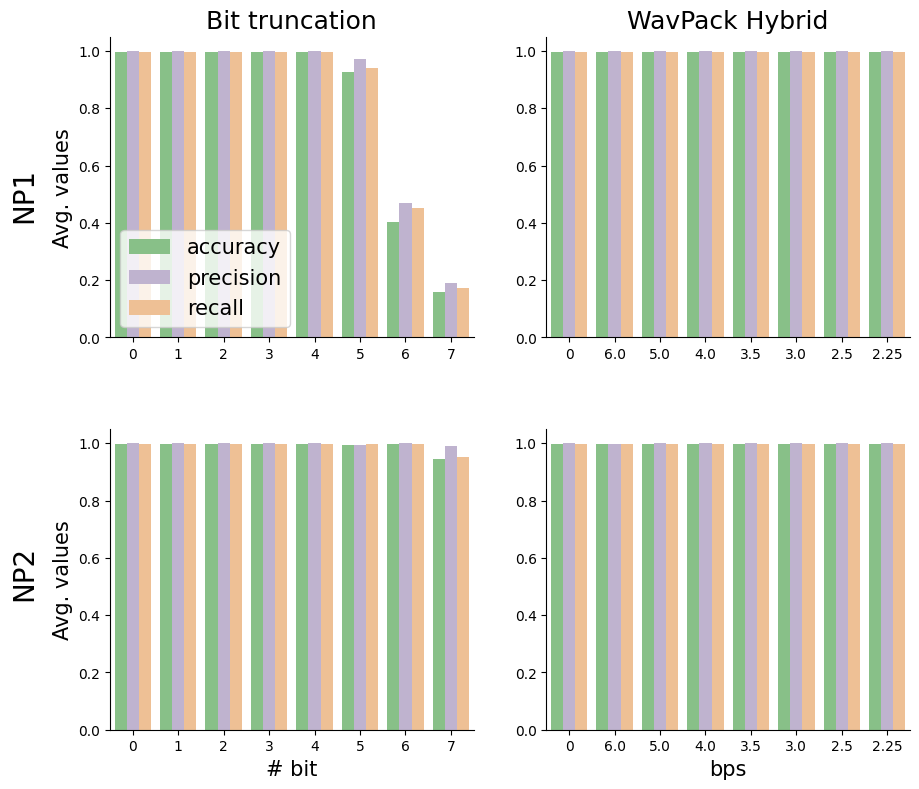

In [61]:
fig_10 = plt.figure(figsize=figsize_multi_2rows)
color = "Accent"

gs = fig_10.add_gridspec(9, 2, hspace=0.2, wspace=0.2)
ax11 = fig_10.add_subplot(gs[:4, 0])
ax12 = fig_10.add_subplot(gs[:4, 1])
ax21 = fig_10.add_subplot(gs[5:, 0])
ax22 = fig_10.add_subplot(gs[5:, 1])

axs = np.array([ax11, ax12, ax21, ax22]).reshape(2, 2)

for probe in probes:
    if "1" in probe:
        row = 0
    else:
        row = 1
    
    res_bit_probe = res_sim_bit.query(f"probe == '{probe}'")
    res_wv_probe = res_sim_wv.query(f"probe == '{probe}'")

    ax = axs[row, 0]
    df_perf = pd.melt(res_bit_probe, id_vars='factor', var_name='metric', value_name='value', 
                      value_vars=('accuracy', 'precision', 'recall'))
    sns.barplot(x='factor', y='value', hue='metric', data=df_perf,
                order=bit_order, ax=ax, palette=color)
    ax.set_xticklabels(bit_labels)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.get_legend().remove()

    ax = axs[row, 1]
    df_perf = pd.melt(res_wv_probe, id_vars='factor', var_name='metric', value_name='value', 
                      value_vars=('accuracy', 'precision', 'recall'))
    sns.barplot(x='factor', y='value', hue='metric', data=df_perf,
                order=wv_order, ax=ax, palette=color)
    ax.set_xticklabels(wv_labels)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.get_legend().remove()

axs[0, 0].set_title("Bit truncation", fontsize=18)
axs[0, 1].set_title("WavPack Hybrid", fontsize=18)
axs[1, 0].set_xlabel("# bit")
axs[1, 1].set_xlabel("bps")
axs[0, 0].set_ylabel("Avg. values")
axs[1, 0].set_ylabel("Avg. values")
axs[0, 0].legend(fontsize=15, loc=3)

prettify_axes(axs, label_fs=15)
fig_10.subplots_adjust(hspace=0.2, wspace=0.2, left=0.1)
_ = fig_10.text(0, 0.68, "NP1", transform=fig_10.transFigure, rotation=90, fontsize=20)
_ = fig_10.text(0, 0.26, "NP2", transform=fig_10.transFigure, rotation=90, fontsize=20)

In [62]:
if save_fig:
    fig_10.savefig(fig_folder / "fig10.pdf")

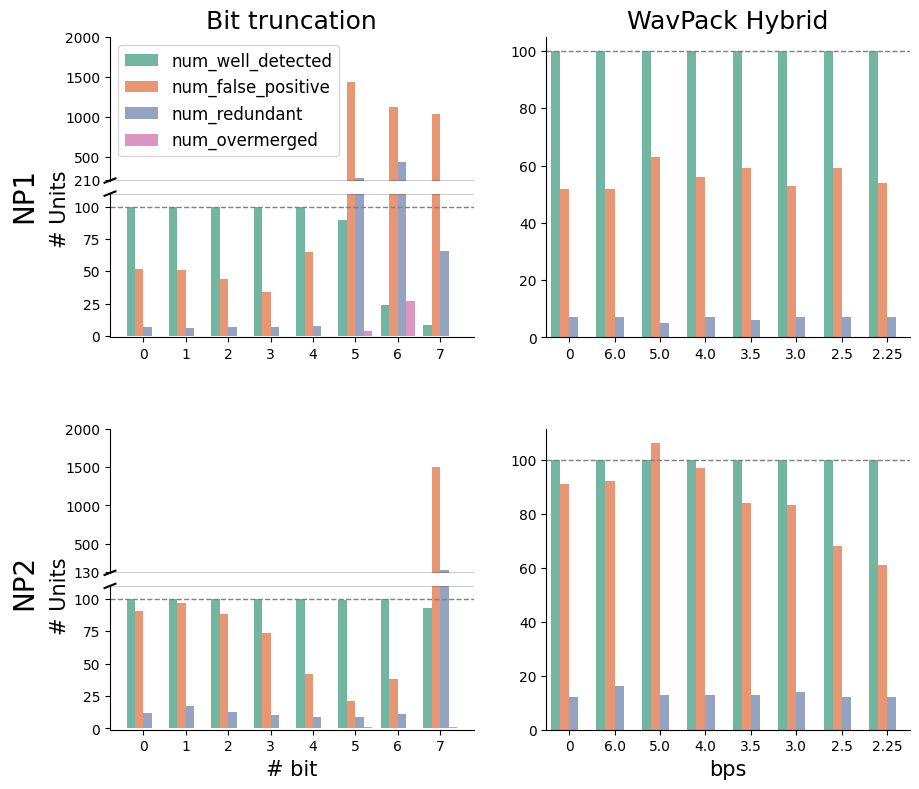

In [63]:
fig_11 = plt.figure(figsize=figsize_multi_2rows)
color = "Set2"

gs = fig_11.add_gridspec(9, 2, hspace=0.2, wspace=0.2)
ax11_top = fig_11.add_subplot(gs[:2, 0])
ax11_bottom = fig_11.add_subplot(gs[2:4, 0])
ax12 = fig_11.add_subplot(gs[:4, 1])
ax21_top = fig_11.add_subplot(gs[5:7, 0])
ax21_bottom = fig_11.add_subplot(gs[7:, 0])
ax22 = fig_11.add_subplot(gs[5:, 1])
ax11 = [ax11_bottom, ax11_top]
ax21 = [ax21_bottom, ax21_top]

axs = [[ax11, ax12], [ax21, ax22]]

ylims = {
    "NP1": [[-1, 110], 200],
    "NP2": [[-1, 110], 120],
}

for probe in probes:
    if "1" in probe:
        row = 0
    else:
        row = 1
    
    res_bit_probe = res_sim_bit.query(f"probe == '{probe}'")
    res_wv_probe = res_sim_wv.query(f"probe == '{probe}'")
    
    df_count = pd.melt(res_bit_probe, id_vars='factor', var_name='Type', value_name='Units', 
             value_vars=('num_well_detected', 'num_false_positive', 'num_redundant', 'num_overmerged'))
    ax_split = axs[row][0]
    ax_bottom = ax_split[0]
    ax_top = ax_split[1]
    sns.barplot(x='factor', y='Units', hue='Type', data=df_count,
                order=bit_order, ax=ax_split[0], palette=color)
    sns.barplot(x='factor', y='Units', hue='Type', data=df_count,
                order=bit_order, ax=ax_split[1], palette=color)
    top_lim = ylims[probe][1]
    bottom_lims = ylims[probe][0]
    ax_split[1].set_ylim(bottom=top_lim)
    yticks = [top_lim + 10] + list(ax_top.get_yticks())
    ax_top.set_yticks(sorted(yticks)[1:])
    ax_top.axhline(top_lim, ls="-", color="k", alpha=0.2)
    ax_top.set_xticks([])
    ax_top.set_xlabel("")
    ax_top.set_ylabel("")
    ax_bottom.set_xlabel("")
    ax_bottom.set_ylabel("")
    ax_bottom.set_ylim(bottom_lims)
    ax_bottom.axhline(bottom_lims[1], ls="-", color="k", alpha=0.2)

    sns.despine(ax=ax_bottom)
    sns.despine(ax=ax_top, bottom=True)

    d = .015
    kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
    ax_top.plot((-d, +d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_bottom.transAxes)
    ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)

    ax_top.get_legend().remove()
    ax_bottom.get_legend().remove()
    ax_bottom.axhline(100, color="grey", ls="--", lw=1)
    ax_bottom.set_xticklabels(bit_labels)

    ax = axs[row][1]
    df_count = pd.melt(res_wv_probe, id_vars='factor', var_name='Type', value_name='Units', 
             value_vars=('num_well_detected', 'num_false_positive', 'num_redundant', 'num_overmerged'))
    sns.barplot(x='factor', y='Units', hue='Type', data=df_count,
                order=wv_order, ax=ax, palette=color)
    ax.set_xticklabels(wv_labels)
    ax.legend(loc=3)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.axhline(100, color="grey", ls="--", lw=1)
    ax.get_legend().remove()

ax11_top.set_title("Bit truncation", fontsize=18)
ax12.set_title("WavPack Hybrid", fontsize=18)
ax21_bottom.set_xlabel("# bit")
ax22.set_xlabel("bps")
ax11_top.legend(fontsize=12)

axs = np.array([ax12, ax21_bottom, ax22])

fig_11.subplots_adjust(left=0.1)
_ = fig_11.text(0.04, 0.65, "# Units", transform=fig_11.transFigure, rotation=90, fontsize=15)
_ = fig_11.text(0.04, 0.22, "# Units", transform=fig_11.transFigure, rotation=90, fontsize=15)
_ = fig_11.text(0, 0.68, "NP1", transform=fig_11.transFigure, rotation=90, fontsize=20)
_ = fig_11.text(0, 0.25, "NP2", transform=fig_11.transFigure, rotation=90, fontsize=20)

prettify_axes(axs, label_fs=15)
fig_11.subplots_adjust(hspace=0.2, wspace=0.2)

In [64]:
if save_fig:
    fig_11.savefig(fig_folder / "fig11.pdf")

### Experimental

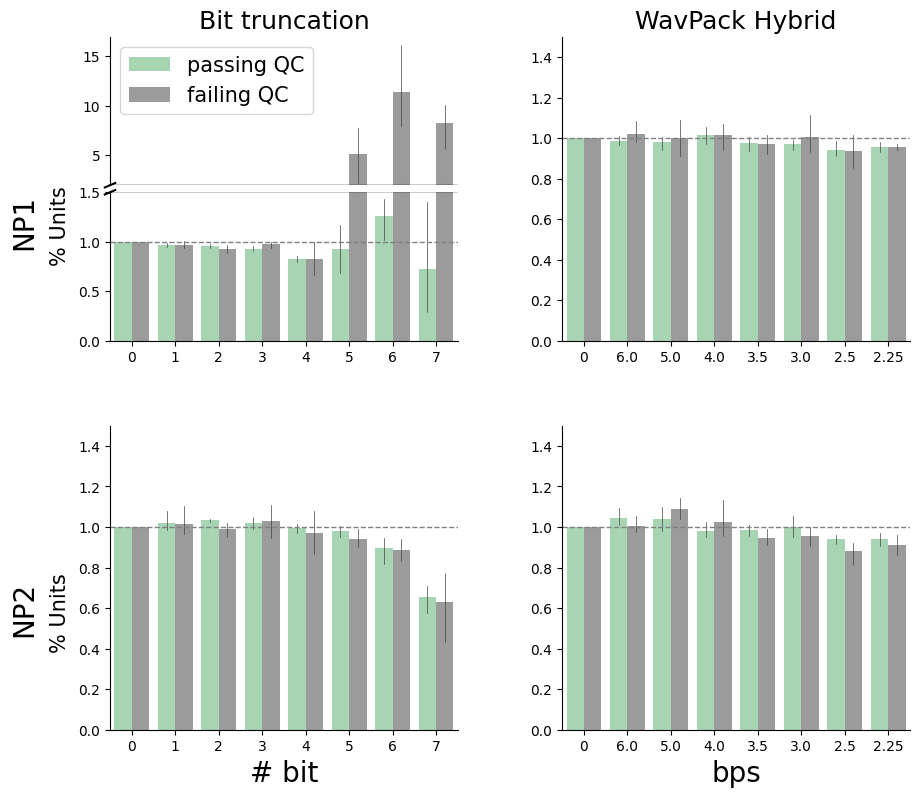

In [97]:
fig_12 = plt.figure(figsize=figsize_multi_2rows)

color = {
    "passing QC": [159/255, 221/255, 177/255],
    "failing QC": [155/255, 155/255, 155/255]
}

gs = fig_12.add_gridspec(9, 2, hspace=0.1, wspace=0.3)
ax11_top = fig_12.add_subplot(gs[:2, 0])
ax11_bottom = fig_12.add_subplot(gs[2:4, 0])
ax12 = fig_12.add_subplot(gs[:4, 1])
ax21 = fig_12.add_subplot(gs[5:, 0])
ax22 = fig_12.add_subplot(gs[5:, 1])
ax11 = [ax11_bottom, ax11_top]

axs = [[ax11, ax12], [ax21, ax22]]

xlim_bit = [-0.5, 7.5]
ylim = [0, 1.5]
top_lim = 2

for probe in probes:
    if "1" in probe:
        row = 0
    else:
        row = 1
    
    res_bit_probe = res_exp_bit.query(f"probe == '{probe}'")
    res_wv_probe = res_exp_wv.query(f"probe == '{probe}'")
    
    # normalize with respect to lossless num units
    for session in np.unique(res_bit_probe.session):
        res_bit_session = res_bit_probe.query(f"session == '{session}'")
        res_bit_0 = res_bit_session.query("factor == 0")
        n_bit_good_units_0 = res_bit_0["n_curated_good_units"].values[0]
        n_bit_bad_units_0 = res_bit_0["n_curated_bad_units"].values[0]
        
        res_bit_probe.loc[res_bit_session.index, "passing QC"] = \
                res_bit_session["n_curated_good_units"] / n_bit_good_units_0
        res_bit_probe.loc[res_bit_session.index, "failing QC"] = \
                res_bit_session["n_curated_bad_units"] / n_bit_bad_units_0

    for session in np.unique(res_wv_probe.session):
        res_wv_session = res_wv_probe.query(f"session == '{session}'")
        res_wv_0 = res_wv_session.query("factor == 0")
        n_wv_good_units_0 = res_wv_0["n_curated_good_units"].values[0]
        n_wv_bad_units_0 = res_wv_0["n_curated_bad_units"].values[0]
        
        res_wv_probe.loc[res_wv_session.index, "passing QC"] = \
                res_wv_session["n_curated_good_units"] / n_wv_good_units_0
        res_wv_probe.loc[res_wv_session.index, "failing QC"] = \
                res_wv_session["n_curated_bad_units"] / n_wv_bad_units_0

    # bit truncation
    df_bit = pd.melt(res_bit_probe, id_vars='factor', var_name='Type', value_name='Units', 
                     value_vars=('passing QC', 'failing QC'))
    if probe == "NP1" and row == 0:
        ax_split = axs[row][0]
        ax_bottom = ax_split[0]
        ax_top = ax_split[1]
        sns.barplot(x='factor', y='Units', hue='Type', data=df_bit,
                    order=bit_order, ax=ax_top, palette=color, errwidth=0.5)
        sns.barplot(x='factor', y='Units', hue='Type', data=df_bit,
                    order=bit_order, ax=ax_bottom, palette=color, errwidth=0.5)
        ax_top.set_ylim(bottom=top_lim)
        ax_top.axhline(top_lim, ls="-", color="k", alpha=0.2)
        ax_top.set_xticks([])
        ax_top.set_xlabel("")
        ax_top.set_ylabel("")
        ax_bottom.set_xlabel("")
        ax_bottom.set_ylabel("")
        ax_bottom.set_ylim(ylim)
        ax_bottom.axhline(ylim[1], ls="-", color="k", alpha=0.2)

        sns.despine(ax=ax_bottom)
        sns.despine(ax=ax_top, bottom=True)

        d = .015
        kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
        ax_top.plot((-d, +d), (-d, +d), **kwargs)
        kwargs.update(transform=ax_bottom.transAxes)
        ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)

        ax_top.get_legend().remove()
        ax_bottom.set_xticklabels(bit_labels)
        ax_top.set_xlim(xlim_bit)
        ax = ax_bottom
    else:
        ax = axs[row][0]
        sns.barplot(x='factor', y='Units', hue='Type', data=df_bit,
                    order=bit_order, ax=ax, palette=color, errwidth=0.5)
        ax.set_xticklabels(bit_labels)

    ax.get_legend().remove()
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xlim(xlim_bit)
    ax.set_ylim(ylim)
    n_good_lossless = 1
    ax.axhline(n_good_lossless, color="grey", ls="--", lw=1)
    
    ax = axs[row][1]
    df_wv = pd.melt(res_wv_probe, id_vars='factor', var_name='Type', value_name='Units', 
                    value_vars=('passing QC', 'failing QC'))
    sns.barplot(x='factor', y='Units', hue='Type', data=df_wv,
                order=wv_order, ax=ax, palette=color, errwidth=0.5)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_ylim(ylim)
    ax.axhline(n_good_lossless, color="grey", ls="--", lw=1)
    ax.get_legend().remove()

               
ax11_top.set_title("Bit truncation", fontsize=18)
ax12.set_title("WavPack Hybrid", fontsize=18)
ax21.set_xlabel("# bit")
ax22.set_xlabel("bps")
ax11_top.legend(fontsize=15, loc=2)

axs = np.array([ax12, ax21, ax22])

prettify_axes(axs, label_fs=20)

fig_12.subplots_adjust(left=0.1)
_ = fig_12.text(0.04, 0.63, "% Units", transform=fig_12.transFigure, rotation=90, fontsize=15)
_ = fig_12.text(0.04, 0.2, "% Units", transform=fig_12.transFigure, rotation=90, fontsize=15)
_ = fig_12.text(0, 0.65, "NP1", transform=fig_12.transFigure, rotation=90, fontsize=20)
_ = fig_12.text(0, 0.22, "NP2", transform=fig_12.transFigure, rotation=90, fontsize=20)

In [73]:
res_exp.groupby(["probe", "strategy", "factor"]).count()["dataset"]

probe  strategy        factor
NP1    bit_truncation  0.00      4
                       1.00      4
                       2.00      4
                       3.00      4
                       4.00      4
                       5.00      4
                       6.00      4
                       7.00      4
       wavpack         0.00      4
                       2.25      4
                       2.50      4
                       3.00      4
                       3.50      4
                       4.00      4
                       5.00      4
                       6.00      4
NP2    bit_truncation  0.00      4
                       1.00      4
                       2.00      4
                       3.00      4
                       4.00      4
                       5.00      4
                       6.00      4
                       7.00      4
       wavpack         0.00      4
                       2.25      4
                       2.50      4
                       3.

In [74]:
if save_fig:
    fig_12.savefig(fig_folder / "fig12.pdf")

## Comparison with lossless

In [81]:
factors_comparisons = {
    "bit_truncation": [0, 1, 2, 3, 4, 5, 6, 7],
    "wavpack": [0, 6, 5, 4, 3, 2.5, 2.25]
}

In [82]:
accuracies_folder = results_lossy_exp_folder / "accuracies"
sessions = np.unique(res_exp.session)
strategies = ["bit_truncation", "wavpack"]

accs_all = {}

for session in sessions:
    for strategy, factors_strategy in factors_comparisons.items():
        for factor in factors_strategy:
            acc_file = accuracies_folder / f"{session}-{strategy}-{factor}.npy"
            acc = np.load(acc_file)
            if session not in accs_all:
                accs_all[session] = {}
            if strategy not in accs_all[session]:
                accs_all[session][strategy] = {}
            accs_all[session][strategy][str(factor)] = acc

In [83]:
comparison_sessions_main = {
    "NP1": "CSHZAD026_2020-09-04_probe00",
    "NP2": "612962_2022-04-13_19-18-04_ProbeB",
}

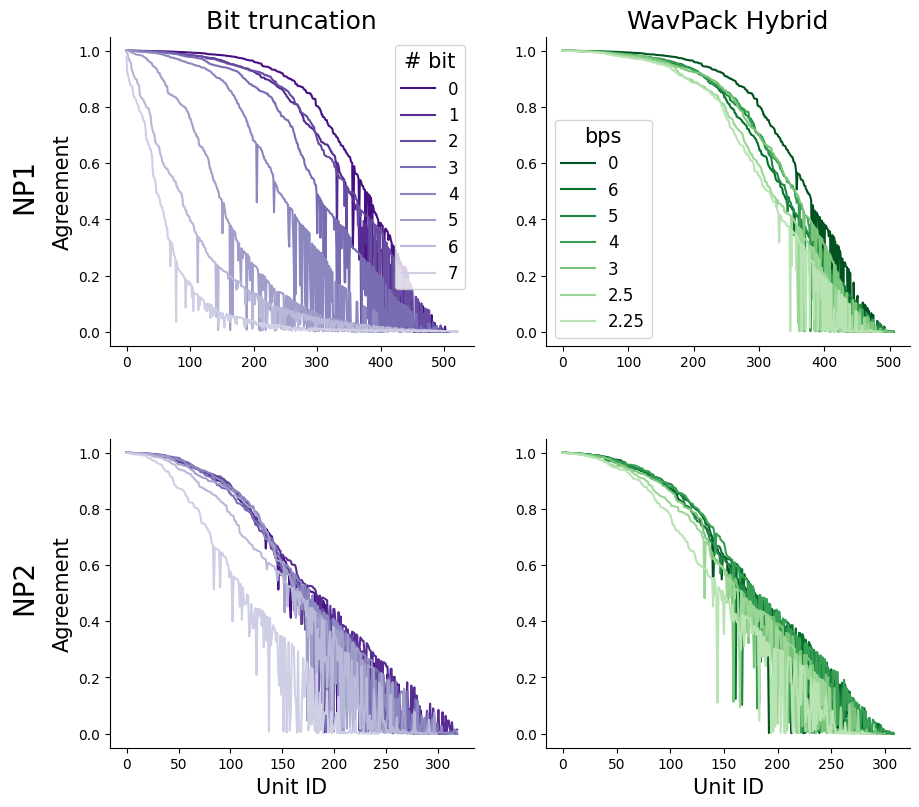

In [84]:
# fig13
fig_13, ax_agrs = plt.subplots(figsize=figsize_multi_2rows, nrows=2, ncols=2)

for probe_name, session in comparison_sessions_main.items():
    accs_session = accs_all[session]
    row_original = res_exp.query(f"session == '{session}'")
    probe_name = row_original.probe.values[0]

    if probe_name == "NP1":
        row = 0
    else:
        row = 1
    for strategy in ["bit_truncation", "wavpack"]:
        if strategy == "bit_truncation":
            colors = bit_colors
            legend_title = "# bit"
            col = 0
        else:
            colors = wv_colors
            legend_title = "bps"
            col = 1
        ax_agr = ax_agrs[row, col]
        acc_strategy = accs_session[strategy]
        for i, factor in enumerate(factors_comparisons[strategy]):
            acc = acc_strategy[str(factor)]
            ax_agr.plot(acc, label=factor, color=colors[str(float(factor))])
        ax_agr.set_ylabel("")
        ax_agr.set_xlabel("")

ax_agrs[0, 0].set_ylabel("Agreement")
ax_agrs[1, 0].set_ylabel("Agreement")
ax_agrs[1, 0].set_xlabel("Unit ID")
ax_agrs[1, 1].set_xlabel("Unit ID")
ax_agrs[0, 0].set_title("Bit truncation", fontsize=18)
ax_agrs[0, 1].set_title("WavPack Hybrid", fontsize=18)
ax_agrs[0, 0].legend(fontsize=12, title="# bit", title_fontsize=15)
ax_agrs[0, 1].legend(fontsize=12, title="bps", title_fontsize=15)

prettify_axes(ax_agrs)
fig_13.subplots_adjust(left=0.1, hspace=0.3, top=0.9)
_ = fig_13.text(0, 0.71, "NP1", transform=fig_13.transFigure, rotation=90, fontsize=20)
_ = fig_13.text(0, 0.265, "NP2", transform=fig_13.transFigure, rotation=90, fontsize=20)

In [85]:
comparison_sessions_supp = {
    "NP1": [
       '625749_2022-08-03_15-15-06_ProbeA',
       '634568_2022-08-05_15-59-46_ProbeA',
       'SWC054_2020-10-05_probe00'
    ],
    "NP2": [
       '595262_2022-02-21_15-18-07_ProbeA',
       '602454_2022-03-22_16-30-03_ProbeB',
       '618384_2022-04-14_15-11-00_ProbeB',
    ]
}

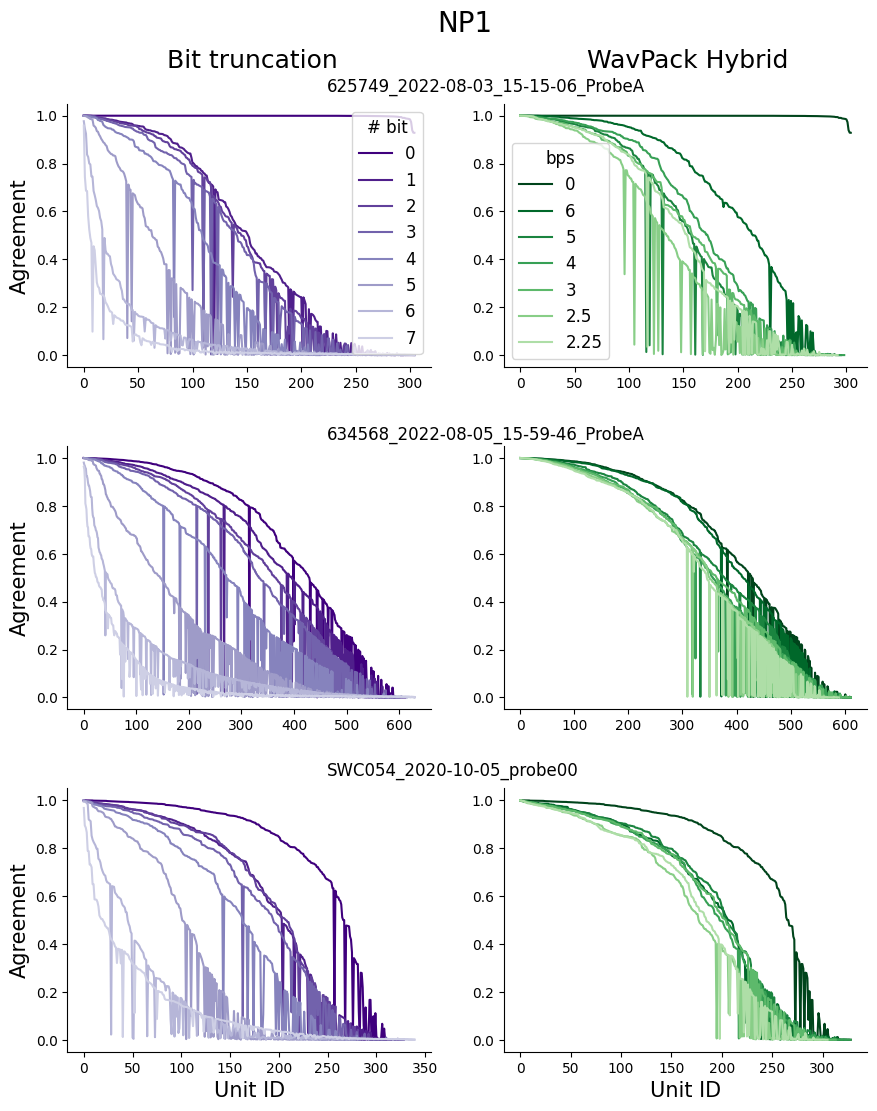

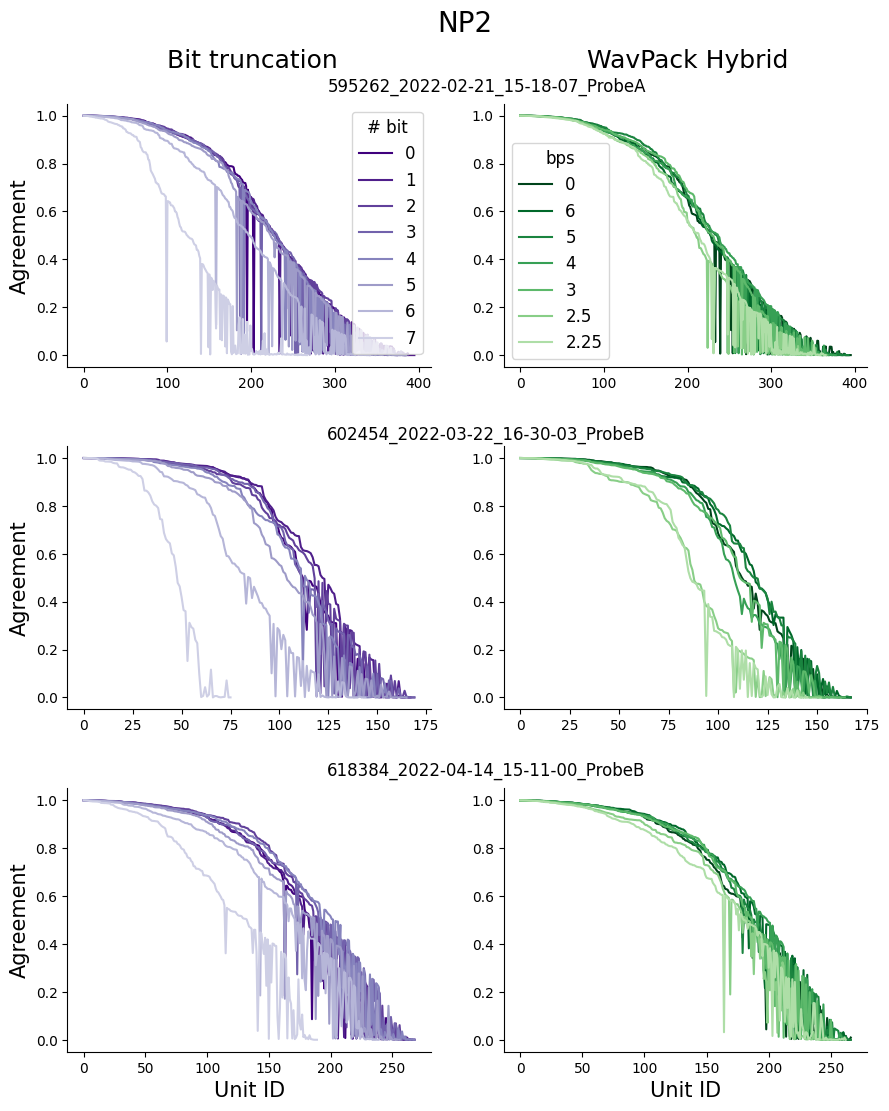

In [86]:
fig_S6, ax_agrs_NP1 = plt.subplots(figsize=figsize_multi_3rows, nrows=3, ncols=2)
fig_S7, ax_agrs_NP2 = plt.subplots(figsize=figsize_multi_3rows, nrows=3, ncols=2)

session_title_y_offsets = [0.91, 0.62, 0.34]

for probe_name, sessions_sup in comparison_sessions_supp.items():
    if probe_name == "NP1":
        fig_S = fig_S6
        axs_agrs = ax_agrs_NP1
    else:
        fig_S = fig_S7
        axs_agrs = ax_agrs_NP2

    for i_s, session in enumerate(sessions_sup):
        accs_session = accs_all[session]
        row_original = res_exp.query(f"session == '{session}'")
        probe_name = row_original.probe.values[0]

        row = i_s
        for strategy in ["bit_truncation", "wavpack"]:
            if strategy == "wavpack":
                cmap = wv_cmap
                col = 1
            else:
                cmap = bit_cmap
                col = 0
            ax_agr = axs_agrs[row, col]
            acc_strategy = accs_session[strategy]
            for i, factor in enumerate(factors_comparisons[strategy]):
                acc = acc_strategy[str(factor)]
                ax_agr.plot(acc, label=factor, color=cmap(i/(len(acc_strategy)+2)))
            ax_agr.set_ylabel("")
            ax_agr.set_xlabel("")

        _ = fig_S.text(0.36, session_title_y_offsets[i_s], session,
                       transform=fig_S.transFigure, fontsize=12)

    axs_agrs[0, 0].set_ylabel("Agreement")
    axs_agrs[1, 0].set_ylabel("Agreement")
    axs_agrs[2, 0].set_ylabel("Agreement")
    axs_agrs[-1, 0].set_xlabel("Unit ID")
    axs_agrs[-1, 1].set_xlabel("Unit ID")
    axs_agrs[0, 0].legend(fontsize=12, title="# bit", title_fontsize=12)
    axs_agrs[0, 1].legend(fontsize=12, title="bps", title_fontsize=12)

    prettify_axes(axs_agrs)

    fig_S.subplots_adjust(left=0.1, hspace=0.3, top=0.9)
    
    _ = fig_S.text(0.2, 0.93, "Bit truncation",
                   transform=fig_S.transFigure, fontsize=18)
    _ = fig_S.text(0.62, 0.93, "WavPack Hybrid",
                   transform=fig_S.transFigure, fontsize=18)
    _ = fig_S.text(0.47, 0.96, probe_name,
                   transform=fig_S.transFigure, fontsize=20)

In [87]:
if save_fig:
    fig_13.savefig(fig_folder / "fig13.pdf")
    fig_S6.savefig(fig_folder / "figS6.pdf")
    fig_S7.savefig(fig_folder / "figS7.pdf")

## Waveform features

Compute dataframe with relative errors

In [88]:
selected_distances = [0, 60]
metrics = ["peak_to_valley", "half_width", "peak_trough_ratio"]

In [89]:
template_metrics = metrics

res_wfs_dist = res_sim_wfs.query(f"distance in {selected_distances}")
df_errors = None
for bit in bit_order[1:]:
    strategy = "bit_truncation"
    new_e_df = res_wfs_dist[["probe", "unit_id", "distance"]].copy()
    new_e_df.loc[:, "strategy"] = [strategy] * len(new_e_df)
    new_e_df.loc[:, "factor"] = [bit] * len(new_e_df)

    for metric in template_metrics:
        metric_gt = f"{metric}_gt"
        metric_tested = f"{metric}_{strategy}_{int(bit)}"
        error = np.abs(res_sim_wfs[metric_tested] - res_sim_wfs[metric_gt]) / np.abs(res_sim_wfs[metric_gt])
        new_e_df.loc[:, f"err_{metric}"] = error
        
    if df_errors is None:
        df_errors = new_e_df
    else:
        df_errors = pd.concat([df_errors, new_e_df])
        
for wv in wv_order[1:]:
    strategy = "wavpack"
    new_e_df = res_wfs_dist[["probe", "unit_id", "distance"]].copy()
    new_e_df.loc[:, "strategy"] = [strategy] * len(new_e_df)
    new_e_df.loc[:, "factor"] = [wv] * len(new_e_df)

    for metric in template_metrics:
        metric_gt = f"{metric}_gt"
        metric_tested = f"{metric}_{strategy}_{wv}"
        error = np.abs(res_sim_wfs[metric_tested] - res_sim_wfs[metric_gt]) / np.abs(res_sim_wfs[metric_gt])
        new_e_df.loc[:, f"err_{metric}"] = error
        
    if df_errors is None:
        df_errors = new_e_df
    else:
        df_errors = pd.concat([df_errors, new_e_df])

In [90]:
df_errors.groupby(["probe", "strategy", "factor", "distance"]).count()["unit_id"]

probe  strategy        factor  distance
NP1    bit_truncation  1.00    0.0         100
                               60.0        100
                       2.00    0.0         100
                               60.0        100
                       3.00    0.0         100
                               60.0        100
                       4.00    0.0         100
                               60.0        100
                       5.00    0.0         100
                               60.0        100
                       6.00    0.0         100
                               60.0        100
                       7.00    0.0         100
                               60.0        100
       wavpack         2.25    0.0         100
                               60.0        100
                       2.50    0.0         100
                               60.0        100
                       3.00    0.0         100
                               60.0        100
                    

In [ ]:
fig_14 = plt.figure(figsize=figsize_multi_3rows)
multiplier = 4
gs = fig_14.add_gridspec((multiplier + 1) * 4, len(template_metrics), hspace=0.5, wspace=0.2, left=0.13)

axs = []
for p_i in range(4):
    ax_cols = []
    for t_i in range(len(template_metrics)):
        if p_i % 2 == 0:
            shift = multiplier // 2
            ax1 = fig_14.add_subplot(gs[multiplier * p_i + p_i:multiplier*p_i + shift + p_i, t_i])
            ax2 = fig_14.add_subplot(gs[multiplier * p_i + shift + p_i:
                                        multiplier * p_i + multiplier + p_i, t_i])
            ax = [ax1, ax2]
        else:
            ax = fig_14.add_subplot(gs[multiplier * p_i + p_i:multiplier * p_i + multiplier + p_i, t_i])
        ax_cols.append(ax)
    axs.append(ax_cols)

ylims = [(-0.01, 0.2), 0.2]

for probe in probes:
    if "1" in probe:
        row = 0
    else:
        row = 2
    for i, metric in enumerate(template_metrics):
        df_errors_bit = df_errors.query("strategy == 'bit_truncation'")
        color = bit_cmap.name

        # bit truncation
        axs_bit = axs[row][i]
        if isinstance(axs_bit, list):
            ax_top = axs_bit[0]
            ax_bottom = axs_bit[1]
            sns.boxenplot(data=df_errors_bit.query(f"probe == '{probe}'"), 
                          x="factor", y=f"err_{metric}", hue="distance",
                          order=bit_order[1:], showfliers=False, ax=ax_top,
                          palette=color)
            sns.boxenplot(data=df_errors_bit.query(f"probe == '{probe}'"), 
                          x="factor", y=f"err_{metric}", hue="distance",
                          order=bit_order[1:], showfliers=False, ax=ax_bottom,
                          palette=color)
            ax_top.set_ylim(bottom=ylims[1])
            ax_top.axhline(ylims[1], ls="-", color="k", alpha=0.2)
            ax_top.set_xticks([])
            ax_top.set_xlabel("")
            ax_top.set_ylabel("")
            ax_bottom.set_xlabel("")
            ax_bottom.set_ylabel("")
            ax_bottom.set_ylim(ylims[0])
            ax_bottom.axhline(ylims[0][1], ls="-", color="k", alpha=0.2)

            sns.despine(ax=ax_bottom)
            sns.despine(ax=ax_top, bottom=True)

            d = .015
            kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
            ax_top.plot((-d, +d), (-d, +d), **kwargs)
            kwargs.update(transform=ax_bottom.transAxes)
            ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)
            
            ax_top.get_legend().remove()
            ax_bottom.axhline(100, color="grey", ls="--", lw=1)
            ax_bottom.set_xticklabels(bit_labels[1:])
            ax = ax_bottom
        else:
            ax = axs_bit
            sns.boxenplot(data=df_errors_bit.query(f"probe == '{probe}'"), 
                          x="factor", y=f"err_{metric}", hue="distance",
                          order=bit_order[1:], showfliers=False, ax=ax_bottom,
                          palette=color)
            
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticklabels(bit_labels[1:])
        ax.set_xlabel("# bit")
        ax.set_title("")
        ax.axhline(0.1, color="grey", ls="--")
        ax.text(0, 0.11, "10%", fontsize=10, color="grey")
        ax.set_ylim(ylims[0])
        ax.get_legend().remove()
        

        df_errors_wv = df_errors.query("strategy == 'wavpack'")
        color = wv_cmap.name
        ax = axs[row + 1][i]
        sns.boxenplot(data=df_errors_wv.query(f"probe == '{probe}'"), 
                      x="factor", y=f"err_{metric}", hue="distance",
                      order=wv_order[1:], showfliers=False, ax=ax,
                      palette=color)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticklabels(wv_labels[1:])
        ax.set_xlabel("bps")
        ax.set_title("")
        ax.axhline(0.1, color="grey", ls="--")
        ax.text(0, 0.11, "10%", fontsize=10, color="grey")
        ax.set_ylim(ylims[0])
        ax.get_legend().remove()

# add legends
ax_legends = [axs[0][0][0], axs[1][0]]
for ax_leg in ax_legends:
    handles, labels = ax_leg.get_legend_handles_labels()
    ax_leg.legend(handles, ["0$\\mu$m", "60$\\mu$m"], loc=2, fontsize=12)

axs[0][0][0].set_title("Peak-to-valley", fontsize=18)
axs[0][1][0].set_title("Half-width", fontsize=18)
axs[0][2][0].set_title("Peak-trough ratio", fontsize=18)
        
_ = fig_14.text(0.07, 0.76, "Bit truncation", transform=fig_14.transFigure, rotation=90, fontsize=12)
_ = fig_14.text(0.07, 0.56, "WavPack Hybrid", transform=fig_14.transFigure, rotation=90, fontsize=12)
_ = fig_14.text(0.07, 0.37, "Bit truncation", transform=fig_14.transFigure, rotation=90, fontsize=12)
_ = fig_14.text(0.07, 0.17, "WavPack Hybrid", transform=fig_14.transFigure, rotation=90, fontsize=12)

_ = fig_14.text(0.035, 0.64, "Relative Errors", transform=fig_14.transFigure, rotation=90, fontsize=15)
_ = fig_14.text(0.035, 0.26, "Relative Errors", transform=fig_14.transFigure, rotation=90, fontsize=15)

_ = fig_14.text(0, 0.68, "NP1", transform=fig_14.transFigure, rotation=90, fontsize=20)
_ = fig_14.text(0, 0.30, "NP2", transform=fig_14.transFigure, rotation=90, fontsize=20)

axs_all = []
for ax_row in axs:
    for ax in ax_row:
        if isinstance(ax, list):
            [axs_all.append(ax_i) for ax_i in ax]
        else: 
            axs_all.append(ax)
prettify_axes(axs_all, label_fs=12)


In [ ]:
if save_fig:
    fig_14.savefig(fig_folder / "fig14.pdf")

## Plot templates

In [ ]:
import spikeinterface.widgets as sw

# load GT waveforms
gt_dict = {}
bit_dict = {}
wv_dict = {}
dsets = ["NP1", "NP2"]
for dset in dsets:
    wfs_folder = results_lossy_sim_folder / f"gt-{dset}" / "waveforms"
    we = si.load_waveforms(wfs_folder, with_recording=False)
    gt_dict[dset] = we
    bit_dict[dset] = {}
    wv_dict[dset] = {}

    for bit in bit_order[1:]:
        wfs_folder = results_lossy_sim_folder / f"waveforms-{dset}-bit_truncation" / f"wf_lossy_bit_truncation_{int(bit)}"
        we = si.load_waveforms(wfs_folder, with_recording=False)
        bit_dict[dset][int(bit)] = we
    for bps in wv_order[1:]:
        wfs_folder = results_lossy_sim_folder / f"waveforms-{dset}-wavpack" / f"wf_lossy_wavpack_{bps}"
        we = si.load_waveforms(wfs_folder, with_recording=False)
        wv_dict[dset][bps] = we

Plot template in the center, and single channels on subplots (main channel, suburb channel)

In [ ]:
# unit ids
unit_ids = dict(
    NP1="#10",
    NP2="#30"
)
dist = 60
radius_um = 100

gt_lw = 3

fig_S8_panels = {}

for dset in dsets:
    fig_S8_panels[dset] = {}
    unit_id = unit_ids[dset]
    we_gt = gt_dict[dset]
    extremum_channels_inds = si.get_template_extremum_channel(we_gt, outputs="index")
    main_channel_ind = extremum_channels_inds[unit_id]
    locs = we_gt.get_channel_locations()
    distances = np.linalg.norm(locs - locs[main_channel_ind], axis=1)
    order = np.argsort(distances)
    idx = np.where(distances[order] > dist)[0][0]
    last_channel_ind = order[idx]
    sparsity = si.compute_sparsity(we_gt, method="radius", radius_um=radius_um)

    fig, ax_pos = plt.subplots()
    channel_inds = sparsity.unit_id_to_channel_indices[unit_id]
    ax_pos.plot(locs[channel_inds, 0], locs[channel_inds, 1], "k.", ls="")

    w = sw.plot_unit_templates(we_gt, sparsity=sparsity, unit_ids=[unit_id], same_axis=True, 
                               unit_colors={unit_id : "k"})
    w.legend.remove()
    w.ax.set_title("")
    w.ax.axis("off")
    ax_pos.plot(*locs[main_channel_ind], "o", markersize=10, markerfacecolor=None)
    ax_pos.plot(*locs[last_channel_ind], "o", markersize=10, markerfacecolor=None)
    ax_pos.axis("off")

    fig_bit_main, ax_bit_main = plt.subplots(ncols=1, figsize=figsize_multi_2rows)
    fig_bit_last, ax_bit_last = plt.subplots(ncols=1, figsize=figsize_multi_2rows)

    
    ts = np.arange(-we.nbefore, we.nafter) / we.sampling_frequency * 1000
    template_main_gt = we_gt.get_template(unit_id)[:, main_channel_ind]
    ax_bit_main.plot(ts, template_main_gt, color="k", label="GT", lw=gt_lw)
    template_last_gt = we_gt.get_template(unit_id)[:, last_channel_ind]
    ax_bit_last.plot(ts, template_last_gt, color="k", label="GT", lw=gt_lw)
    for i, (bit, we) in enumerate(bit_dict[dset].items()):
        color = bit_colors[str(float(bit))]
        template = we.get_template(unit_id)
        template_main = template[:, main_channel_ind]
        ax_bit_main.plot(ts, template_main, color=color, label=int(bit))
        template_last = template[:, last_channel_ind]
        ax_bit_last.plot(ts, template_last, color=color, label=int(bit))

    # legend
    ax_bit_main.legend(ncol=4, fontsize=12)
    ax_bit_last.legend(ncol=4, fontsize=12)

    # scale bar
    ax_bit_main.plot([-3, -2], [-50, -50], color="k", lw=3)
    ax_bit_main.plot([-3, -3], [-50, -40], color="k", lw=3)
    ax_bit_main.text(-2.7, -60, "1ms", fontsize=12)
    ax_bit_main.text(-2.9, -45, "10$\\mu$V", fontsize=12)

    ax_bit_last.plot([-3, -2], [-20, -20], color="k", lw=3)
    ax_bit_last.plot([-3, -3], [-20, -10], color="k", lw=3)
    ax_bit_last.text(-2.7, -19, "1ms", fontsize=12)
    ax_bit_last.text(-2.9, -15, "10$\\mu$V", fontsize=12)
    
    ax_bit_main.axis("off")
    ax_bit_last.axis("off")  

    
    fig_wv_main, ax_wv_main = plt.subplots(ncols=1, figsize=figsize_multi_2rows)
    fig_wv_last, ax_wv_last = plt.subplots(ncols=1, figsize=figsize_multi_2rows)

    ts = np.arange(-we.nbefore, we.nafter) / we.sampling_frequency * 1000
    template_main_gt = we_gt.get_template(unit_id)[:, main_channel_ind]
    ax_wv_main.plot(ts, template_main_gt, color="k", label="GT", lw=gt_lw)
    template_last_gt = we_gt.get_template(unit_id)[:, last_channel_ind]
    ax_wv_last.plot(ts, template_last_gt, color="k", label="GT", lw=gt_lw)
    for i, (bps, we) in enumerate(wv_dict[dset].items()):
        color = wv_colors[str(float(bps))]
        template = we.get_template(unit_id)
        template_main = template[:, main_channel_ind]
        ax_wv_main.plot(ts, template_main, color=color, label=bps)
        template_last = template[:, last_channel_ind]
        ax_wv_last.plot(ts, template_last, color=color, label=bps)
    
    # legend
    ax_wv_main.legend(ncol=4, fontsize=12)
    ax_wv_last.legend(ncol=4, fontsize=12)

    # scale bar
    ax_wv_main.plot([-3, -2], [-50, -50], color="k", lw=3)
    ax_wv_main.plot([-3, -3], [-50, -40], color="k", lw=3)
    ax_wv_main.text(-2.7, -60, "1ms", fontsize=12)
    ax_wv_main.text(-2.9, -45, "10$\\mu$V", fontsize=12)

    ax_wv_last.plot([-3, -2], [-20, -20], color="k", lw=3)
    ax_wv_last.plot([-3, -3], [-20, -10], color="k", lw=3)
    ax_wv_last.text(-2.7, -19, "1ms", fontsize=12)
    ax_wv_last.text(-2.9, -15, "10$\\mu$V", fontsize=12)

    ax_wv_main.axis("off")
    ax_wv_last.axis("off")
    
    fig_S8_panels[dset]["gt"] = w.figure
    fig_S8_panels[dset]["bit_main"] = fig_bit_main
    fig_S8_panels[dset]["bit_lat"] = fig_bit_last
    fig_S8_panels[dset]["wv_main"] = fig_wv_main
    fig_S8_panels[dset]["wv_last"] = fig_wv_last

In [ ]:
if save_fig:
    for fig_dset in fig_S8_panels:
        for fig_name, fig in fig_S8_panels[fig_dset].items():
            fig.savefig(fig_folder / f"figS8-{fig_dset}-{fig_name}.pdf")